In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import wandb
import torch
from matplotlib.gridspec import GridSpec
import matplotlib.colors as clr
import seaborn as sns
import pandas as pd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

maxi=0


# Download data from Weights & Biases

In [ ]:
def download_sweep_as_long_dataframe(
    project_name,
    sweep_name,
    entity=None,
    metric_prefix='test',
    last_step_only=False
):
    """
    Downloads runs in a W&B sweep and returns a pandas DataFrame
    """
    api = wandb.Api()
    sweep_path = f"{entity}/{project_name}/{sweep_name}" if entity else f"{project_name}/{sweep_name}"
    sweep = api.sweep(sweep_path)

    all_rows = []

    for run in sweep.runs:
        try:
            history = run.history(keys=None)
            if history.empty:
                continue

            # Filter metric columns
            metric_cols = [col for col in history.columns if col.startswith(metric_prefix)]
            if not metric_cols:
                continue

            base_cols = [c for c in ['_step', '_timestamp', '_runtime'] if c in history.columns]
            history = history[base_cols + metric_cols]

            # Optionally keep only the last row
            if last_step_only:
                history = history.iloc[[-1]]

            # Add config parameters
            config = run.config
            for key, value in config.items():
                history[key] = [value] * len(history)

            # Add run info
            history['run_id'] = run.id
            history['run_name'] = run.name


            # Melt into long format
            melted = history.melt(
                id_vars=base_cols + list(config.keys()) + ['run_id', 'run_name'],
                value_vars=metric_cols,
                var_name='metric',
                value_name='value'
            )

            all_rows.append(melted)

        except Exception as e:
            print(f"Skipping run {run.id} due to error: {e}")
            continue

    if all_rows:
        return pd.concat(all_rows, ignore_index=True)
    else:
        return pd.DataFrame()


In [ ]:
data_set_name='RMS'
sparsity=''
model='SNN'
sweep_by_dataset={'RMS_SNN': "your_sweep_ID",} #fill in ID here
df = download_sweep_as_long_dataframe(
    project_name="CC_SNN",
    sweep_name=sweep_by_dataset[f'{data_set_name}_{model}{sparsity}'],
    entity=None,
    last_step_only=True
)

print(df.head())
df.to_csv(f'all_test_metrics_{data_set_name}_{model}{sparsity}.csv')

   _step    _timestamp      _runtime  i  j     lr  nr  hil  batch noise  ...  \
0    228  1.746652e+09  16702.233948  0  1  0.003   1  0.9    256  None  ...   
1    228  1.746652e+09  16702.233948  0  1  0.003   1  0.9    256  None  ...   
2    228  1.746652e+09  16702.233948  0  1  0.003   1  0.9    256  None  ...   
3    228  1.746652e+09  16702.233948  0  1  0.003   1  0.9    256  None  ...   
4    228  1.746652e+09  16702.233948  0  1  0.003   1  0.9    256  None  ...   

   params_from_target  teacher_weight_init  N_train_only_weights  \
0         [I_c, beta]               normal                     0   
1         [I_c, beta]               normal                     0   
2         [I_c, beta]               normal                     0   
3         [I_c, beta]               normal                     0   
4         [I_c, beta]               normal                     0   

   teacher_neuron_model weight_scaling_factor  teacher_low_rank_sparse  \
0                   LIF             

# Process data

In [ ]:

def get_df_means(df,data_set_name,sparsity=0.5,aslist=False):
    """get means per metric and run settings"""
    
    sweep_config = {
            'method': 'grid',
            'name': f'{data_set_name}:students',
            'metric': {
                'goal': 'maximize',
                'name': 'val_acc'
            },
            'parameters': {
                'hil': {'values': [0.0,0.2,0.4,0.6,0.8,0.9,1.0]},
                'epochs': {'values': [80,]},
                'range': {'values': [1]},
                'hidden_mode': {'values': ['mse',]},
                'SG_scale': {'values': [50,]}, #300,20
                'lr': {'values': [0.003,]}, #0.01, 0.0001
                'batch': {'values': [256]},
                'weight_scaling_factor': {'values': [1.0]},
                'teacher_params': {'values': ['oi','ow','wi']},
                'teacher_weight_init': {'values': ['normal']},#['uniform','normal']},
                'teacher_low_rank_sparse': {'values': [None,1.0]},
                'teacher_sparsity': {'values': [sparsity]},#,0.8,0.5,0.2]},
                'train_params': {'values': ['ov','oi']},
                'train_layer': {'values': ['hil','out']},
                'train_loss': {'values': ['mse','nll']},
                'low_rank_sparse': {'values': [None,1.0]},
                'sparsity': {'values': [1.0]}, #WARNING - when changing this value, also change conditions above!!! #otherwise, teacher's pattern cannot be learned/ alternative: provide sparsity mask,#,0.8,0.5,0.2]},
                'synapse_noise': {'values': [0.002]},
                'weight_init': {'values': ['normal']},#['uniform','normal']},
                'neuron_model': {'values': ['LIF']},#'BLK_nonsp','LIF']},
                'teacher_neuron_model': {'values': ['LIF']},#'BLK_nonsp','LIF']},
                'shuffle': {'values': [0]}
                
            }
    }
    cols=list(sweep_config['parameters'].keys())

    cols.append('metric')
    df_None=df.copy()
    df_None['low_rank_sparse']=df['low_rank_sparse'].fillna('None')
    df_None['teacher_low_rank_sparse']=df['teacher_low_rank_sparse'].fillna('None')
    df_means = df_None.groupby(cols)['value'].apply(np.array).reset_index()
    return df_means

In [ ]:
def filter_means(df_means,filters):
    """filter data frame with means for specific settings"""
    df_means =df_means.copy()

    if filters:
        for key, val in filters.items():
            if val is None:
                df_means = df_means[df_means[key].isna()]
            else:
                df_means = df_means[df_means[key] == val]
    return df_means

In [ ]:

def get_values(df,metric,hil_add,sparsity=0.5,aslist=False,topK=5,metric_topK='test_loss',sort_incr=True,teacher_lowrank='None',lowrank='None'):
    filters = {
        'task':{'metric': metric,          
            'train_loss': 'nll',
            'train_layer':'hil',
            'low_rank_sparse': lowrank,
            'teacher_low_rank_sparse': teacher_lowrank,
            'hil': 0.0,
            'teacher_sparsity': sparsity
        },
        'out':{'metric': metric,             
            'train_loss': 'mse',
            'train_layer':'out',
            'low_rank_sparse': lowrank,
            'teacher_low_rank_sparse': teacher_lowrank,
            'hil': 0.0,
            'teacher_sparsity': sparsity
        },
        'hid':{'metric': metric,             
            'train_loss': 'mse',
            'train_layer':'hil',
            'low_rank_sparse': lowrank,
            'teacher_low_rank_sparse': teacher_lowrank,
            'hil': hil_add,
            'teacher_sparsity': sparsity
        },
        'task+hid':{'metric': metric,             
            'train_loss': 'nll',
            'train_layer':'hil',
            'low_rank_sparse': lowrank,
            'teacher_low_rank_sparse': teacher_lowrank,
            'hil': hil_add,
            'teacher_sparsity': sparsity
        },
    }

    
    students=['oi','ov']
    teachers = ['oi','ow','wi']
    objectives = list(filters.keys())
    colors=['#7d54b2', '#e57439', '#5ac5db', ]

    N=len(students)
    M=len(teachers)
    K=len(objectives)

    values = np.zeros((N,M,K))
    values_shuffled = np.zeros((N,M,K))
    values_std = np.zeros((N,M,K))
    values_shuffled_std =np.zeros((N,M,K))

    all_loss =np.zeros((N,M,K),dtype=object)# [[[i for i in students] for j in teachers] for k in objectives]
    all_values =np.zeros((N,M,K),dtype=object)# [[[i for i in students] for j in teachers] for k in objectives]
    all_values_shuffled =np.zeros((N,M,K),dtype=object)# [[[i for i in students] for j in teachers] for k in objectives]
    best_idxs = np.zeros((N,M,K),dtype=object)#[[[i for i in students] for j in teachers] for k in objectives]

    for k, (name,filter) in enumerate(filters.items()):
        filter2=filter.copy()
        filter2['metric']=metric_topK
        for i,student in enumerate(students):
            filter2['train_params'] = student
            for j,teacher in enumerate(teachers):
                filter2['teacher_params'] = teacher
                filtered_df=filter_means(df, filter2)
                assert len(filtered_df)<=1
                if len(filtered_df)==1:
                    
                    all_loss[i,j,k]= filtered_df['value'].values[0]#[k][j][i] = filtered_df['value'].values[0]
                    if sort_incr:
                        best_idxs[i,j,k] = np.argsort(np.array(all_loss[i,j,k]))[:topK]
                    else:
                        best_idxs[i,j,k] = np.argsort(np.array(all_loss[i,j,k]))[::-1][:topK]

                

    for k, (name,filter) in enumerate(filters.items()):
        for i,student in enumerate(students):
            filter['train_params'] = student
            for j,teacher in enumerate(teachers):
                filter['teacher_params'] = teacher
                filtered_df=filter_means(df, filter)
                assert len(filtered_df)<=1
                if len(filtered_df)==1:
                    #print(f'student {student} teacher {teacher} obj {name} -> {filtered_df['value'].values[0]}')
                    curr_values= filtered_df['value'].values[0][best_idxs[i,j,k]]
                    all_values[i,j,k]=curr_values
                    values[i,j,k] = np.nanmean(curr_values)
                    values_std[i,j,k] = np.nanstd(curr_values)
                    #print(f'student: {curr_values}')


    for k, (name,filter) in enumerate(filters.items()):
        filter=filter.copy()
        unprefixed = filter['metric'].removeprefix("test")
        shuffled_metric = f"test_shuffled{unprefixed}"
        filter['metric'] = shuffled_metric
        for i,student in enumerate(students):
            filter['train_params'] = student
            for j,teacher in enumerate(teachers):
                filter['teacher_params'] = teacher
                filtered_df=filter_means(df, filter)
                assert filtered_df.shape[0] <=1
                if len(filtered_df)==1:
                    curr_values= filtered_df['value'].values[0][best_idxs[i,j,k]]
                    all_values_shuffled[i,j,k]=curr_values
                    values_shuffled[i,j,k] = np.mean(curr_values)
                    values_shuffled_std[i,j,k] = np.std(curr_values)

        

    values_shuffled_small=np.mean(values_shuffled,axis=(0))#np.zeros((M,K))

    values_shuffled_small=np.mean(values_shuffled,axis=(0))

    values_shuffled_std_small = np.sqrt((np.square(values_shuffled_std[0,:,:])+ np.square(values_shuffled_std[1,:,:]))/2)



    return values, values_shuffled_small,values_shuffled_std_small, values_std,objectives,all_values,all_values_shuffled

In [ ]:
metric='test_acc'
df = pd.read_csv(f'all_test_metrics_RMS_SNN.csv')
hil_add=0.0
aslist=False
data_set_name='RMS'
df_means = get_df_means(df,data_set_name)
values, values_shuffled_small,values_shuffled_std_small, values_std,objectives,all_values,arr_values_shuffled=get_values(df_means,metric,hil_add,sparsity=0.5)

In [ ]:
def friedmantest(all_values,axis,idx1,idx2):

    N = all_values.shape[axis]
    print(f'{N} groups')
    groups=[]
    groups_df={}
    if axis==0:
        for i in np.arange(N):
            groups.append(all_values[i,idx1,idx2])
            groups_df[i]= all_values[i,idx1,idx2]

    elif axis==1:
        for i in np.arange(N):
            groups.append(all_values[idx1,i,idx2])
            groups_df[i]= all_values[idx1,i,idx2]

    elif axis==2:
        for i in np.arange(N):
            groups.append(all_values[idx1,idx2,i])
            groups_df[i]= all_values[idx1,idx2,i]

    for group in groups:
        print(group)
        print(f'mean of group is {np.mean(group)}')
    print(groups_df)
    groups_df = pd.DataFrame(groups_df)
    res = friedmanchisquare(*groups)

    if res.pvalue < 0.05:
        post = np.array(sp.posthoc_conover_friedman((groups_df)))
        print(f'res: {res}post:{post}, shape: {post.shape}')

    else:
        post=None

    return res.pvalue,post

3 groups
[0.82421875 0.81328124 0.828125   0.92265624 0.90781248]
mean of group is 0.8592187404632569
[0.89140624 0.95234376 0.95859373 0.95234376 0.58828127]
mean of group is 0.8685937523841858
[0.81484377 0.85390627 0.83984375 0.72109377 0.74296874]
mean of group is 0.7945312619209289
{0: array([0.82421875, 0.81328124, 0.828125  , 0.92265624, 0.90781248]), 1: array([0.89140624, 0.95234376, 0.95859373, 0.95234376, 0.58828127]), 2: array([0.81484377, 0.85390627, 0.83984375, 0.72109377, 0.74296874])}


In [ ]:

def add_labels(x, y,metric):
    plt.rcParams['font.family'] = 'Helvetica'

    for i in range(len(x)):
        if 'corr' in metric:
            plt.text(x[i], y[i], f'.{int(np.round(y[i]*100))}',ha='center',fontsize=10,stretch='extra-condensed',fontweight='black') 
        else:
            plt.text(x[i], y[i], int(np.round(y[i])),ha='center',fontsize=10,stretch='extra-condensed',fontweight='black') 
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"]

def get_min_max_rel(values_shuffled_all,values_std_all,i,logscale,y_all):
    min_shuffled=0#np.min(values_shuffled)
    if logscale:
        min=0.01
    min=0
    max_shuffled=np.max(values_shuffled_all)
    print(max_shuffled)
    values_std_rel=values_std_all/np.abs(values_shuffled_all) #TODO: what factor to divide by?

    values_std = values_std_rel[i,:,:]
    max = np.max(y_all + values_std_rel)
    return min,max,min_shuffled,max_shuffled,values_std

def sig_within_teacher(ax,x,arr_values,i,y,shift,metric=None):
    #4,3
    N = len(x)
    x_num=np.arange(N)

    if N==3:
        x_pos=[-0.185,0.0,0.185]
    elif N==4:
        x_pos = [-0.25,-0.085,0.085,0.25]
    elif N==2:
        x_pos = [-0.085,0.085]

    for j in x_num:
        print(f'friedmann test for student {i}, objective {j}')
        p,post = friedmantest(arr_values,1,i,j)
        if p < 0.05:
            assert post is not None
            M=len(post)
            groups=np.arange(M)
            for m in groups:
                for k in groups:
                    if m >k:
                        text=None
                        
                        add= np.abs(m-k)*shift
                        if post[m,k]<0.05:
                            text='*'
                        if post[m,k] < 0.01:
                            text='**'
                        if post[m,k] < 0.001:
                            text='***'
                        if text is not None:
                            print(f'shift is {shift}, ymax is {np.max(y[j,:])}, add is {add}')
                            #text=text+f'{m}-{k}'
                            #ax.text(j-(M/2-(m+k+1)/2)*0.25, np.max(y[j,:])+add,text,ha='center',fontsize=10,color='black') 
                            print(metric)
                            if metric is not None and 'corr' in metric:
                                height=np.min(np.array([1.0,np.max(y[j,:])+add]))
                                barplot_annotate_brackets(ax,m,k, text, j+x_pos+0.05,height,barh=shift)
                            else:
                                barplot_annotate_brackets(ax,m,k, text, j+x_pos+0.05,np.max(y[j,:])+add,barh=shift)
        else:
            text='n.s.'
            ax.text(j, np.max(y[j,:]),text,ha='center',fontsize=16,color='black') 
            #barplot_annotate_brackets(m, k, text, x_num, y[j,:])
            
        
def barplot_annotate_brackets(ax,num1, num2, data, center, height, yerr=None, dh=.05, barh=.05):
    """ 
    adapted from -> https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
    if num1>num2:
        num=num1
        num1=num2
        num2=num
    print(num1,num2)

    lx, ly = center[num1], height
    rx, ry = center[num2], height
    

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    #ax_y0, ax_y1 = plt.gca().get_ylim()
    #dh *= (ax_y1 - ax_y0)
    dh=barh
    #barh *= (ax_y1 - ax_y0)

    y = np.max(np.array([ly, ry])) + dh
    print(f'ly,ry, dh in plot {ly}, {ry}, {dh}')
    print(f'height in plot {height}')
    print(f'y in plot {y}')
    print(f'barh in plot {barh}')


    barx = [lx, lx, rx, rx]
    bary = [y+barh/2, y+barh, y+barh, y+barh/2]
    mid = ((lx+rx)/2, y+barh)

    ax.plot(barx, bary, c='black',linewidth=0.7,zorder=2)

    ax.text(*mid, data, ha='center',fontsize=7,stretch='extra-condensed',color='black',zorder=2)     
        
        

def plot_bar(ax,ax2, x,values,values_std,values_shuffled,labels,colors,metric,add_labels=False,second_baseline=None):
    N = len(x)
    x_num=np.arange(N)
    M = len(labels)

    if M==3:
        x_pos=[-0.185,0.0,0.185]
    elif M==4:
        x_pos = [-0.25,-0.085,0.085,0.25]
    elif M==2:
        x_pos = [-0.085,0.085]

    for j in np.arange(M):

        ax.bar(x_num+x_pos[j], values[:,j], width=0.12,label = labels[j], color=colors[j], alpha = 0.8)
        if add_labels:
            add_labels(x_num+x_pos[j],values[:,j], metric)

        if j==M-1:
            label_t='shuffled teacher'
            label_t2='between teachers'
        else:
            label_t=None
            label_t2=None
        if values_shuffled is not None:
            if ax2 is None:
                ax.bar(x_num+x_pos[j],values_shuffled[:,j], width=0.13, fill=False, edgecolor='gray',zorder=-2,label = label_t)
            else:
                ax2.bar(x_num+x_pos[j],values_shuffled[:,j], width=0.13, fill=False, edgecolor='gray',zorder=-2,label =label_t)
        if second_baseline is not None:
            if ax2 is None:
                ax.bar(x_num+x_pos[j],second_baseline[:,j], width=0.13, fill=False, edgecolor='red',zorder=-2,label = label_t2)
            else:
                ax2.bar(x_num+x_pos[j],second_baseline[:,j], width=0.13, fill=False, edgecolor='red',zorder=-2,label =label_t2)

        ax.errorbar(x_num+x_pos[j],values[:,j],values_std[:,j],fmt='none', color=colors[j],zorder=-2)

def ax_labels(fig,ax1,mode,min,max,logscale,x,x_names,ax2=None,min_shuffled=None,max_shuffled=None,title=None,titles=True,legend=False):
    
    for pos in ['right', 'top']:
        plt.gca().spines[pos].set_visible(False)
    sns.despine()
    pre=''
    add=''
    if mode=='difference':
        add=' difference'
    elif mode=='relative':
        pre='relative '
    if 'MSE' in metric:
        #plt.ylabel(f'{pre}MSE{add}')
        ax1.set_ylabel(f'{pre}MSE{add}')
        if mode=='relative' or mode=='difference':
            ax2.set_ylabel('MSE',color='gray')
            ax2.tick_params(axis='y', labelcolor='gray') 
            if mode=='difference':
                ax2.set_ylim(min,max)
            else:
                ax2.set_ylim(min_shuffled,max_shuffled)
                #if len(x)==3:
                ax1.hlines(1,-0.315,len(x)-1+ 0.315,linestyles='--',color='gray')
            ax2.spines['right'].set_color('gray')
    elif 'corr' in metric:
        ax1.set_ylabel(f'{pre}corr{add}')
        if mode=='relative' or mode=='difference':
            ax2.set_ylabel('corr',color='gray')
            ax2.tick_params(axis='y', labelcolor='gray')
            ax2.set_ylim(min,max)
            ax2.spines['right'].set_color('gray') 
        max=1.2
        #min=0.0
    elif 'sync' in metric:
        ax1.set_ylabel(f'{pre}spike sync{add}')
        if mode=='relative' or mode=='difference':
            ax2.set_ylabel('spike sync',color='gray')
            ax2.tick_params(axis='y', labelcolor='gray') 
            ax2.set_ylim(min,max)
            ax2.spines['right'].set_color('gray')
    elif 'acc' in metric:
        if mode=='absolute':
            max=1.0
            min=0.0
            ax1.set_yticks(np.linspace(0,1,3), [0.0,0.5,1.0])
        
        ax1.set_ylabel(f'{pre}accuracy{add}')
        if mode=='difference':
            ax2.set_ylabel('acc',color='gray')
            ax2.tick_params(axis='y', labelcolor='gray') 
            ax2.set_ylim(0,1)
            ax2.spines['right'].set_color('gray')
        
    
    if logscale:
        ax1.set_yscale('log')
        if mode=='relative':
            ax2.set_yscale('log')
            ax2.set_ylim(0.001,max_shuffled)
        ax1.set_ylim(0.001,max)
        
        #plt.yticks([1,100,1000])
    else:
        ax1.set_ylim(min,max)
      
    ax1.set_xticks(np.arange(len(x)), x_names)

    if titles:
        if title is not None:
            plt.title(title)
    if mode !='absolute':
        ax2.set_zorder(1)
        ax1.set_zorder(2)
        ax1.patch.set_visible(False)

    ax1.grid(axis='y',zorder=-1.0, color='lightgray', alpha=0.3)

    if legend:
        fig.subplots_adjust(right=0.75)

        ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.,ncol=legend)
    
    
    plt.show()
    print(f'min: {min}, max: {max}, shuffled mac {max_shuffled}')     


def show_teacher_student_loss(teachers,students,data_set_name,model,metric, mode, logscale,hil_add,plot='loss',sparsity='',titles=False,tests=False,legend=False,figsize=(5,4)):
    """
    different plots can be generated
    -> set 'plot'
     to 'dataset_task' if you trained students on several data sets (RMS, RML, SHD)
     to 'task_0_SNN_RNN_oi' if you want to see initial effect of providing only connectome without objectives
    """
    
    teacher_names=['single-neuron', 'weights', 'both']
    df = pd.read_csv(f'all_test_metrics_{data_set_name}_{model}{sparsity}.csv')
    df_means = get_df_means(df,data_set_name)
    values_all, values_shuffled_all,values_shuffled_std_all, values_std_all,objectives,arr_values,arr_values_shuffled = get_values(df_means,metric,hil_add)

    colors=['#7d54b2', '#e57439', '#5ac5db', ]

    min = np.nanmin(np.array([np.nanmin(values_all - values_std_all)-0.01,0,np.nanmin(values_shuffled_all)-0.01]))
    max = np.nanmax(np.array([np.nanmax(values_all + values_std_all),np.nanmax(values_shuffled_all)]))
    
    if mode=='relative' or mode=='difference':
        if mode=='relative':
            y_all = values_all / values_shuffled_all
        elif mode=='difference':
            print(values_all[0,0,0])
            print(values_shuffled_all[0,0])
            y_all=values_all-values_shuffled_all
        
        min = np.min(np.array([np.min(y_all - values_std_all)-0.01,np.min(values_shuffled_all)-0.01]))
        max = np.max(y_all + values_std_all)
    
    if plot=='loss':
        for i,student in enumerate(students):
            fig, ax1 = plt.subplots(figsize=figsize)

            values = values_all[i,:,:]
            values_shuffled = values_shuffled_all
            values_std = values_std_all[i,:,:]

            if mode== 'absolute':
                plot_bar(ax1,None,objectives,values.T, values_std.T,values_shuffled.T,teachers,colors,metric)

                if tests:
                    sig_within_teacher(ax1,objectives,arr_values,i,values.T,shift=max/20)

                ax_labels(fig,ax1,mode,min,max,logscale,objectives,objectives,title=f'obj_{student}',titles=titles,legend=legend)

                

            elif mode=='relative' or mode=='difference':
                ax2 = ax1.twinx()
                y=y_all[i,:,:]
                if mode=='relative':
                    min,max,min_shuffled,max_shuffled, values_std=get_min_max_rel(values_shuffled_all,values_std_all,i,logscale,y_all)
                else:
                    min_shuffled=min
                    max_shuffled=max
                plot_bar(ax1,ax2,objectives,y.T, values_std.T,values_shuffled.T,teachers,colors,metric)
                if mode=='relative':
                    arr_values_rel = arr_values/arr_values_shuffled

                    if tests:
                        sig_within_teacher(ax1,objectives,arr_values_rel,i,y.T,shift=max/20)
                ax_labels(fig,ax1,mode,min,max,logscale,objectives,objectives,ax2,min_shuffled,max_shuffled,title=f'obj_{student}',titles=titles,legend=legend)
                
    
    elif plot=='lowrank_control':
        students=['ov', 'ov_lr', 'oi']
        idx_student=[1,1,0]
        teacher_lowrank=1.0
        lowrank=['None',1.0,'None']
        
        N = len(objectives)
        M = len(students)

        all_results = np.zeros((M,N,3)) # students x objectives x mean,std,shuffled
        all_lists = np.zeros((M,N,1),dtype='object') # students x objectives x mean,std,shuffled
        for i,student in enumerate(students):
            values_all, values_shuffled_all,values_shuffled_std_all, values_std_all,objectives,arr_values,arr_values_shuffled = get_values(df_means,metric,hil_add,sparsity=0.5,aslist=False,topK=5,metric_topK='test_loss',sort_incr=True,teacher_lowrank=teacher_lowrank,lowrank=lowrank[i])

            all_results[i,:,0] = values_all[idx_student[i],-1,:]
            all_results[i,:,1] = values_std_all[idx_student[i],-1,:]
            all_results[i,:,2] = values_shuffled_all[-1,:]
            all_lists[i,:,0] = arr_values[idx_student[i],-1,:]

        baseline = np.mean(all_results[:,:,2],axis=(0,1))
        all_results[:,:,2]=baseline

        min=0
        max=np.nanmax(np.array([np.nanmax(all_results[:,:,0]+all_results[:,:,1]), np.nanmax(all_results[:,:,2])]))

        fig, ax1 = plt.subplots(figsize=figsize)

        if mode== 'absolute':
            print(f'mode is absolute')
            print(all_results[:,:,0].shape)
            print(all_results[:,:,0])
            print('plot now')
            print(f'all results in plot: {all_results[:,:,0]}')
            plot_bar(ax1,None,objectives,all_results[:,:,0].T, all_results[:,:,1].T,all_results[:,:,2].T,students,colors,metric)

            if tests:
                all_lists_reshaped= np.moveaxis(all_lists, -1, 0)#is currently M x N x 1, shoudl be 1 x M x N?
                print(f' reshaped should be 4x3x1, is {all_lists_reshaped.shape}')
                #all_results is currently M,N,3, should be N x M
                sig_within_teacher(ax1,objectives,all_lists_reshaped,0,all_results[:,:,0].T,shift=max/20,metric=metric)

            ax_labels(fig,ax1,mode,min,max,logscale,objectives,objectives,title=f'obj_{student}',titles=titles,legend=legend)

                
            '''
            elif mode=='relative' or mode=='difference':
                ax2 = ax1.twinx()
                y=y_all[i,:,:]
                if mode=='relative':
                    min,max,min_shuffled,max_shuffled, values_std=get_min_max_rel(values_shuffled_all,values_std_all,i,logscale,y_all)
                else:
                    min_shuffled=min
                    max_shuffled=max
                plot_bar(ax1,ax2,objectives,y.T, values_std.T,values_shuffled.T,teachers,colors,metric)
                if mode=='relative':
                    arr_values_rel = arr_values/arr_values_shuffled

                    if tests:
                        sig_within_teacher(ax1,objectives,arr_values_rel,i,y.T,shift=max/20)
                ax_labels(fig,ax1,mode,min,max,logscale,objectives,objectives,ax2,min_shuffled,max_shuffled,title=f'obj_{student}',titles=titles,legend=legend)'''




    elif plot=='table_structure':
        for i,student in enumerate(students):
            values = values_all[i,:,:]
            values_shuffled = values_shuffled_all
            values_std = values_std_all[i,:,:]

            fig, ax1 = plt.subplots(figsize=figsize)
            print(teachers)
            teachers=teachers[-1]

            if mode== 'absolute':
                print(values.shape)
                print(values)
                print(teachers)
                print(objectives)
                plot_bar(ax1,None,teachers,values[:,-1,:], values_std[:,-1,:],values_shuffled[-1,:],objectives,colors2,metric)
                ax_labels(fig,ax1,mode,min,max,logscale,teachers,teacher_names,title=f'teach_{student}',titles=titles,legend=legend)

            elif mode=='relative' or mode=='difference':
                ax2 = ax1.twinx()
                y=y_all[i,:,:]

                if mode=='relative':     
                    
                    min,max,min_shuffled,max_shuffled, values_std=get_min_max_rel(values_shuffled_all,values_std_all,i,logscale,y_all)

                    plot_bar(ax1,ax2,teachers,y, values_std,values_shuffled,objectives,colors2,metric)

                else:
                    plot_bar(ax1,ax2,teachers,y, values_std[:,:],values_shuffled,objectives,colors2,metric)
                ax_labels(fig,ax1,mode,min,max,logscale,teachers,teacher_names,ax2,min_shuffled,max_shuffled,title=f'teach_{student}',titles=titles,legend=legend)

                 
    elif plot=='dataset_task':
        values_all = np.zeros((2,3,4)) # 3 data sets
        values_std_all = np.zeros((2,3,4)) 
        values_shuffled_all = np.zeros((3,4)) 
        values_shuffled_std_all = np.zeros((3,4)) 
        data_set_names=['RMS','RML','SHD']
        arr_values = np.zeros((2,3,4),dtype='object')
        arr_values_shuffled=np.zeros((2,3,4),dtype='object')
        for i,data_set_name in enumerate(data_set_names):
            try:
                if 'test' in metric:
                    df = pd.read_csv(f'all_test_metrics_{data_set_name}_{model}{sparsity}.csv')
                elif 'train' in metric:
                    df = pd.read_csv(f'all_train_metrics_{data_set_name}_{model}{sparsity}.csv')
                df_means = get_df_means(df,data_set_name)
                values, values_shuffled,values_shuffled_std, values_std,objectives,arr_values_c,arr_values_shuffled_c = get_values(df_means,metric,hil_add)

                values_all[:,i,:]=values[:,-1,:]
                values_std_all[:,i,:]=values_std[:,-1,:]
                arr_values[:,i,:]=arr_values_c[:,-1,:]
                arr_values_shuffled[:,i,:]=arr_values_shuffled_c[:,-1,:]

                values_shuffled_all[i,:]=values_shuffled[-1,:]
                values_shuffled_std_all[i,:]=values_shuffled_std[-1,:]
            except:
                pass
        
        colors2= ['tab:blue','tab:purple','tab:pink']#mpl.colormaps['Accent'].colors
        for i,student in enumerate(students):
            min = np.nanmin(np.array([np.nanmin(values_all[i,:,:] - values_std_all[i,:,:])-0.01,0,np.nanmin(values_shuffled_all)-0.01]))
            max = np.nanmax(values_all[i,:,:] + values_std_all[i,:,:])

            if mode=='relative' or mode=='difference':
                if mode=='relative':
                    y_all = values_all / values_shuffled_all
                elif mode=='difference':
                    y_all=values_all-values_shuffled_all
                
                min = np.nanmin(np.array([np.nanmin(y_all[i,:,:] - values_std_all[i,:,:])-0.01,np.nanmin(values_shuffled_all)-0.01]))
                max = np.nanmax(np.array([np.nanmax(y_all[i,:,:] + values_std_all[i,:,:]),np.nanmax(values_shuffled_all)]))
            values = values_all[i,:,:]
            values_shuffled = values_shuffled_all
            values_std = values_std_all[i,:,:]

            fig, ax1 = plt.subplots(figsize=figsize)
            
            if mode== 'absolute':
                #plot_bar(ax1,None,data_set_names,values, values_std,values_shuffled,objectives,colors2,metric)
                #ax_labels(fig,ax1,mode,min,max,logscale,data_set_names,data_set_names,title=f'data_{student}',titles=titles,legend=legend)
                if 'corr' in metric:
                    teacher_baseline = np.zeros((4,3))
                    for k,data_set_name in enumerate(data_set_names):
                        teacher_baseline[:,k] = np.load(f'teacher_corrs/mean_teacher_corr_{data_set_name}_{model}.npy')
                    
                else:
                    teacher_baseline=None
                print(f'teacher baseline: {teacher_baseline}')
                plot_bar(ax1,None,objectives,values.T, values_std.T,None,data_set_names,colors2,metric,second_baseline=teacher_baseline)
                if tests:
                    sig_within_teacher(ax1,objectives,arr_values[:,:,:],i,values.T,shift=max/20)
                plt.title(model)
                plt.xlabel('Objective')
                
                ax_labels(fig,ax1,mode,min,max,logscale,objectives,objectives,title=f'data_{student}',titles=titles,legend=legend)

            elif mode=='relative' or mode=='difference':
                ax2 = ax1.twinx()
                y=y_all[i,:,:]

                if 'corr' in metric and mode=='difference':
                    teacher_baseline = np.zeros((4,3))
                    for k,data_set_name in enumerate(data_set_names):
                        teacher_baseline[:,k] = np.load(f'teacher_corrs/mean_teacher_corr_{data_set_name}_{model}.npy')
                    print(f'teacher baseline: {teacher_baseline}')
                    y_all = values_all-teacher_baseline.T
                    y=y_all[i,:,:]
                    min=np.min(y)
                    max=np.max(y)
                    min_shuffled=0
                    max_shuffled=np.max(teacher_baseline)
                    
                    
                else:
                    teacher_baseline=None

                if mode=='relative':
                    min_shuffled=0#np.min(values_shuffled)
                    min=0
                    max_shuffled=np.nanmax(values_shuffled)
                    #TODO: change back once SHD is here
                    values_std_rel=values_std_all/values_shuffled_all
                    values_std = values_std_all[i,:,:]

                    max = np.nanmax(y_all[0,:,:] + values_std_rel[0,:,:])
                    #plot_bar(ax1,ax2,data_set_names,y, values_std_rel[i,:,:],values_shuffled,objectives,colors2,metric) 
                    plot_bar(ax1,ax2,objectives,y.T, values_std_rel[i,:,:].T,values_shuffled.T,data_set_names,colors2,metric) 

                    if tests:
                        print(arr_values_shuffled)
                        arr_values_rel = np.zeros((2,3,4),dtype='object')
                        arr_values_rel = arr_values/arr_values_shuffled
                        sig_within_teacher(ax1,objectives,arr_values_rel,i,y.T,shift=max/20)
                else:
                    #plot_bar(ax1,ax2,data_set_names,y, values_std,values_shuffled,objectives,colors2,metric)
                    plot_bar(ax1,ax2,objectives,y.T, values_std.T,None,data_set_names,colors2,metric)
                

                #ax_labels(fig,ax1,mode,min,max,logscale,data_set_names,data_set_names,ax2,min_shuffled,max_shuffled,title=f'data_{student}',titles=titles,legend=legend)
                ax_labels(fig,ax1,mode,min,max,logscale,objectives,objectives,ax2,min_shuffled,max_shuffled,title=f'data_{student}',titles=titles,legend=legend)

    elif plot=='task_0':
        values_all = np.zeros((2,3,4)) # 3 data sets
        values_std_all = np.zeros((2,3,4)) 
        values_shuffled_all = np.zeros((3,4)) 
        values_shuffled_std_all = np.zeros((3,4)) 
        data_set_names=['RMS','RML','SHD']
        arr_values = np.zeros((2,3,4),dtype='object')
        arr_values_shuffled=np.zeros((2,3,4),dtype='object')
        for i,data_set_name in enumerate(data_set_names):
            try:
                df = pd.read_csv(f'all_test_metrics_{data_set_name}_{model}{sparsity}.csv')
                df_means = get_df_means(df,data_set_name)
                values, values_shuffled,values_shuffled_std, values_std,objectives,arr_values_c,arr_values_shuffled_c = get_values(df_means,metric,hil_add)

                values_all[:,i,:]=values[:,-1,:]
                values_std_all[:,i,:]=values_std[:,-1,:]
                
                arr_values[:,i,:]=arr_values_c[:,-1,:]
                arr_values_shuffled[:,i,:]=arr_values_shuffled_c[:,-1,:]

                values_shuffled_all[i,:]=values_shuffled[-1,:]
                values_shuffled_std_all[i,:]=values_shuffled_std[-1,:]
            except:
                pass
        min=np.min(values_all-values_std)-0.1
        max=np.max(values_all-values_std)
        if mode=='relative' or mode=='difference':
            if mode=='relative':
                y_all = values_all / values_shuffled_all
            elif mode=='difference':
                y_all=values_all-values_shuffled_all
            
            min = np.nanmin(np.array([np.nanmin(y_all - values_std_all)-0.01,np.nanmin(values_shuffled_all)-0.01]))
            max = np.nanmax(np.array([np.nanmax(y_all + values_std_all),np.nanmax(values_shuffled_all)]))
        values = values_all[:,:,2]
        print(values_std_all[:,:,2].shape,values_shuffled_all[:,2][np.newaxis,:].shape)
        values=np.concatenate((values_all[:,:,2], values_shuffled_all[:,2][np.newaxis,:]), axis=0)
        #values_shuffled = values_shuffled_all
        #values_std = values_std_all[:,:,2]
        values_std=np.concatenate((values_std_all[:,:,2], values_shuffled_std_all[:,2][np.newaxis,:]), axis=0)
        students.append('shuffled')
        print(values.shape,values_std.shape)

        fig, ax1 = plt.subplots(figsize=figsize)
        colors3=['tab:blue','tab:orange','gray']
        
        if mode== 'absolute':
            #plot_bar(ax1,None,data_set_names,values, values_std,values_shuffled,objectives,colors2,metric)
            #ax_labels(fig,ax1,mode,min,max,logscale,data_set_names,data_set_names,title=f'data_{student}',titles=titles,legend=legend)
            print(values.T.shape)
            if 'acc' in metric:
                chance=np.array([[0.5,0.1,0.05],[0.5,0.1,0.05],[0.5,0.1,0.05]]).T
            else:
                if model=='SNN':
                    chance=np.array([[0.06031472, 0.09170705, 0.091562  ],[0.06031472, 0.09170705, 0.091562  ],[0.06031472, 0.09170705, 0.091562  ]]).T
                else:
                    chance=np.array([[0.0751626 , 0.09486665, 0.11666753],[0.0751626 , 0.09486665, 0.11666753],[0.0751626 , 0.09486665, 0.11666753]]).T
            shuffled=np.array([values_shuffled_all[:,2],values_shuffled_all[:,2],values_shuffled_all[:,2]]).T
            plot_bar(ax1,None,data_set_names,values_all[:,:,2].T, values_std_all[:,:,2].T,shuffled,students,colors3,metric)
            if tests:
                raise NotImplementedError
                sig_within_teacher(ax1,data_set_names,arr_values[:,:,:],i,values.T,shift=max/20)
            ax_labels(fig,ax1,mode,min,max,logscale,data_set_names,data_set_names,title=f'',titles=titles,legend=legend)
        if mode=='difference':
            #plot_bar(ax1,None,data_set_names,values, values_std,values_shuffled,objectives,colors2,metric)
            #ax_labels(fig,ax1,mode,min,max,logscale,data_set_names,data_set_names,title=f'data_{student}',titles=titles,legend=legend)
            print(values.T.shape)
            if 'acc' in metric:
                chance=np.array([[0.5,0.1,0.05],[0.5,0.1,0.05],[0.5,0.1,0.05]]).T
            else:
                chance=None
            ax2 = ax1.twinx()
            plot_bar(ax1,ax2,data_set_names,values.T-chance, values_std.T,chance,students,colors3,metric)
            if tests:
                raise NotImplementedError
                sig_within_teacher(ax1,data_set_names,arr_values[:,:,:],i,values.T,shift=max/20)
            max=np.max(values.T+ values_std.T)
            min=0
            ax_labels(fig,ax1,mode,min,max,logscale,data_set_names,data_set_names,title=f'',titles=titles,legend=legend,ax2=ax2,min_shuffled=0,max_shuffled=1)
    if plot=='task_heatmap':
        hil_levels=[0,0.2,0.4,0.6,0.8,0.9]
        values_all = np.zeros((2,3,6,4)) # 3 data sets
        values_std_all = np.zeros((2,3,6,4)) 
        data_set_names=['RMS','RML','SHD']
        arr_values = np.zeros((2,3,4),dtype='object')
        arr_values_shuffled=np.zeros((2,3,4),dtype='object')
        for i,data_set_name in enumerate(data_set_names):
            try:
                df = pd.read_csv(f'all_test_metrics_{data_set_name}_{model}{sparsity}.csv')
                df_means = get_df_means(df,data_set_name)
                for j,hil_add in enumerate(hil_levels):
                    values, values_shuffled,values_shuffled_std, values_std,objectives,arr_values_c,arr_values_shuffled_c = get_values(df_means,metric,hil_add)

                    values_all[:,i,j,:]=values[:,-1,:]
                    values_std_all[:,i,j,:]=values_std[:,-1,:]
                
            except:
                pass
        for j,obj in enumerate(objectives):
            fig,axs = plt.subplots(1,2)
            cmap = plt.get_cmap('nipy_spectral')
            # Create a subset of the colormap
            start = 0.45  # Starting point (0.0 to 1.0)
            end = 0.95  # Ending point (0.0 to 1.0)
            colors = cmap(np.linspace(start, end, 1000))
            new_cmap = mcolors.ListedColormap(colors).reversed()
            if 'corr' in metric:
                vmax=1
            else:
                vmax = np.max(values_all[:,:,:,j])
                new_cmap=new_cmap.reversed()
            axs[0].imshow(values_all[0,:,:,j],vmin=np.min(values_all[:,:,:,j]),vmax=vmax,cmap=new_cmap)
            im=axs[1].imshow(values_all[1,:,:,j],vmin=np.min(values_all[:,:,:,j]),vmax=vmax,cmap=new_cmap)
            fig.colorbar(im, ax=axs, shrink=0.6)
            plt.title(f'{obj}')
            plt.show()


    elif plot=='task_0_SNN_RNN_oi':
        values_all = np.zeros((2,2,3,4)) #2 students,2 models, 3 data sets, 4 objectives?
        values_std_all = np.zeros((2,2,3,4)) 
        values_shuffled_all = np.zeros((2,3,4)) 
        values_shuffled_std_all = np.zeros((2,3,4)) 
        data_set_names=['RMS','RML','SHD']
        arr_values = np.zeros((2,2,3,4),dtype='object')
        arr_values_shuffled=np.zeros((2,2,3,4),dtype='object')
        models = ['SNN','RNN']
        for k, model in enumerate(models):
            for i,data_set_name in enumerate(data_set_names):
                try:
                    df = pd.read_csv(f'all_test_metrics_{data_set_name}_{model}{sparsity}.csv')
                    df_means = get_df_means(df,data_set_name)
                    values, values_shuffled,values_shuffled_std, values_std,objectives,arr_values_c,arr_values_shuffled_c = get_values(df_means,metric,hil_add)

                    values_all[:,k,i,:]=values[:,-1,:]
                    values_std_all[:,k,i,:]=values_std[:,-1,:]
                    
                    arr_values[:,k,i,:]=arr_values_c[:,-1,:]
                    arr_values_shuffled[:,k,i,:]=arr_values_shuffled_c[:,-1,:]

                    values_shuffled_all[k,i,:]=values_shuffled[-1,:]
                    values_shuffled_std_all[k,i,:]=values_shuffled_std[-1,:]
                except:
                    pass
        
        for i, student in enumerate(students):
            min=np.min(values_all[:,:,:,2]-values_std_all[i,:,:,2])-0.1
            max=np.max(values_all[:,:,:,2]-values_std_all[i,:,:,2])
            if mode=='relative' or mode=='difference':
                if mode=='relative':
                    y_all = values_all / values_shuffled_all
                elif mode=='difference':
                    y_all=values_all-values_shuffled_all
                
                min = np.nanmin(np.array([np.nanmin(y_all[i,:,:,2] - values_std_all[i,:,:,2])-0.01,np.nanmin(values_shuffled_all[:,:,2])-0.01]))
                max = np.nanmax(np.array([np.nanmax(y_all[i,:,:,2] + values_std_all[i,:,:,2]),np.nanmax(values_shuffled_all[:,:,2])]))

            fig, ax1 = plt.subplots(figsize=figsize)
            colors3=['tab:cyan','mediumblue','gray']
            
            if mode== 'absolute':
                #plot_bar(ax1,None,data_set_names,values, values_std,values_shuffled,objectives,colors2,metric)
                #ax_labels(fig,ax1,mode,min,max,logscale,data_set_names,data_set_names,title=f'data_{student}',titles=titles,legend=legend)
                print(values.T.shape)

                plot_bar(ax1,None,data_set_names,values_all[i,:,:,2].T, values_std_all[i,:,:,2].T,values_shuffled_all[:,:,2].T,models,colors3,metric)
                plt.xlabel('Data set')
                if tests:
                    raise NotImplementedError
                    sig_within_teacher(ax1,data_set_names,arr_values[:,:,:],i,values.T,shift=max/20)
                ax_labels(fig,ax1,mode,min,max,logscale,data_set_names,data_set_names,title=f'',titles=titles,legend=legend)
            if mode=='difference':
                #plot_bar(ax1,None,data_set_names,values, values_std,values_shuffled,objectives,colors2,metric)
                #ax_labels(fig,ax1,mode,min,max,logscale,data_set_names,data_set_names,title=f'data_{student}',titles=titles,legend=legend)
                print(values.T.shape)
                ax2 = ax1.twinx()
                plot_bar(ax1,ax2,data_set_names,y_all[i,:,:,2].T, values_std_all[i,:,:,2].T,values_shuffled_all[:,:,2].T,models,colors3,metric)
                if tests:
                    raise NotImplementedError
                    sig_within_teacher(ax1,data_set_names,arr_values[:,:,:],i,values.T,shift=max/20)
                max=np.max(values.T+ values_std.T)
                min=0
                ax_labels(fig,ax1,mode,min,max,logscale,data_set_names,data_set_names,title=f'',titles=titles,legend=legend,ax2=ax2,min_shuffled=0,max_shuffled=1)

            

    elif plot=='dataset_sparsity':
        values_all = np.zeros((2,3,3,4)) # 3 data sets, 3 sparsity
        values_std_all = np.zeros((2,3,3,4)) 
        values_shuffled_all = np.zeros((3,3,4)) 
        values_shuffled_std_all = np.zeros((3,3,4)) 
        arr_values = np.empty((2,3,3,4),dtype='object') 
        arr_values_shuffled = np.empty((2,3,3,4),dtype='object') 
        sparsities=[0.8,0.5,0.2]
        sp_labels=['_sp','','_sp']

        data_set_names=['RMS','RML','SHD']
        for i,data_set_name in enumerate(data_set_names):
            for j, sparsity in enumerate(sparsities):
                try:
                    df = pd.read_csv(f'all_test_metrics_{data_set_name}_{model}{sp_labels[j]}.csv')
                    df_means = get_df_means(df,data_set_name,sparsity)
                    values, values_shuffled,values_shuffled_std, values_std,objectives,arr_values_c,arr_values_shuffled_c = get_values(df_means,metric,hil_add,sparsity)

                    values_all[:,i,j,:]=values[:,-1,:]
                    values_std_all[:,i,j,:]=values_std[:,-1,:]
                    arr_values[:,i,j,:]=arr_values_c[:,-1,:]
                    arr_values_shuffled[:,i,j,:]=arr_values_shuffled_c[:,-1,:]

                    print(values_shuffled.shape)

                    values_shuffled_all[i,j,:]=values_shuffled[-1,:]
                    values_shuffled_std_all[i,j,:]=values_shuffled_std[-1,:]
                except:
                    pass

        min = np.nanmin(np.array([np.nanmin(values_all[0,:,:,:] - values_std_all[0,:,:,:])-0.01,0,np.nanmin(values_shuffled_all)-0.01]))
        max = np.nanmax(values_all[0,:,:,:] + values_std_all[0,:,:,:])

        if mode=='relative' or mode=='difference':
            if mode=='relative':
                y_all = values_all / values_shuffled_all
            elif mode=='difference':
                y_all=values_all-values_shuffled_all
            
            min = np.nanmin(np.array([np.nanmin(y_all[0,:,:,:] - values_std_all[0,:,:,:] )-0.01,np.nanmin(values_shuffled_all[:,:,:] )-0.01]))
            max = np.nanmax(np.array([np.nanmax(y_all[0,:,:,:] + values_std_all[0,:,:,:] ),np.nanmax(values_shuffled_all[:,:,:] )]))
        
            

        for k,data_set_name in enumerate(data_set_names):
            
            for i,student in enumerate(students[:1]):
                values = values_all[i,k,:,:]
                values_shuffled = values_shuffled_all[k,:,:]
                values_std = values_std_all[i,k,:,:]

                fig, ax1 = plt.subplots(figsize=figsize)
                
                if mode== 'absolute':
                    #plot_bar(ax1,None,sparsities,values, values_std,values_shuffled,objectives,colors2,metric)
                    #ax_labels(fig,ax1,mode,min,max,logscale,sparsities,sparsities,title=f'sparse_{data_set_name}_{student}',titles=titles,legend=legend)
                    plot_bar(ax1,None,objectives,values.T, values_std.T,values_shuffled.T,sparsities,colors2,metric)
                    if tests:
                        sig_within_teacher(ax1,objectives,arr_values[:,k,:,:],i,values.T,shift=max/20)
                    ax_labels(fig,ax1,mode,min,max,logscale,objectives,objectives,title=f'sparse_{data_set_name}_{student}',titles=titles,legend=legend)
                    

                elif mode=='relative' or mode=='difference':
                    
                    ax2 = ax1.twinx()
                    y=y_all[i,k,:,:]


                    if mode=='relative':
                        min_shuffled=0#np.min(values_shuffled)
                        min=0
                        max_shuffled=np.nanmax(values_shuffled)
                        values_std_rel=values_std_all/values_shuffled_all
                        values_std = values_std_all[i,:,:]
                        print(f'shuffled shape: {values_shuffled.shape}, values: {values_shuffled[:,0]}')
                        max = np.nanmax(y_all[0,k,:,:]  + values_std_rel[0,k,:,:] )

                        

                        #plot_bar(ax1,ax2,sparsities,values, values_std_rel[i,k,:,:],values_shuffled,objectives,colors2,metric)
                        plot_bar(ax1,ax2,objectives,values.T, values_std_rel[i,k,:,:].T,values_shuffled.T,sparsities,colors2,metric)
                        if tests:
                            arr_values_rel = arr_values[:,k,:,:]/arr_values_shuffled[:,k,:,:]
                            sig_within_teacher(ax1,objectives,arr_values_rel,i,y.T,shift=max/20)

                    else:
                        #plot_bar(ax1,ax2,sparsities,values, values_std,values_shuffled,objectives,colors2,metric)
                        plot_bar(ax1,ax2,objectives,values.T, values_std.T,values_shuffled.T,sparsities,colors2,metric)
                    #ax_labels(fig,ax1,mode,min,max,logscale,sparsities,sparsities,ax2,min_shuffled,max_shuffled,title=f'sparse_{data_set_name}_{student}',titles=titles,legend=legend)
                    ax_labels(fig,ax1,mode,min,max,logscale,objectives,objectives,ax2,min_shuffled,max_shuffled,title=f'sparse_{data_set_name}_{student}',titles=titles,legend=legend)
                    

    return values_all, values_shuffled_all,values_shuffled_std_all, values_std_all,objectives

In [ ]:

def get_table_obj_metrics(data_set_name,model,metric, hil_add,sparsity='',tests=False,student=0):
    df = pd.read_csv(f'all_test_metrics_{data_set_name}_{model}{sparsity}.csv')
    df_means = get_df_means(df,data_set_name)
    if model=='RNN':
        metrics=['test_acc', 'test_MSE_V_out_all', 'test_corr_V_out_all','test_MSE_V_hidden_unrec', 'test_corr_V_hidden_unrec', 'test_MSE_beta_hidden_unrec','test_MSE_I_c_hidden_unrec']
        metric_names=['Task acc', 'MSE output', 'Corr output', 'MSE hidden', 'Corr hidden', 'MSE tau','MSE I_c']
    else:
        metrics=['test_acc', 'test_MSE_V_out_all', 'test_corr_V_out_all','test_MSE_V_hidden_unrec', 'test_corr_V_hidden_unrec','test_sync_SPK_hidden_unrec', 'test_MSE_beta_hidden_unrec','test_MSE_I_c_hidden_unrec']
        metric_names=['Task acc', 'MSE output', 'Corr output', 'MSE hidden', 'Corr hidden','Spike sync', 'MSE tau','MSE I_c']
    values_all, values_shuffled_all,values_shuffled_std_all, values_std_all,objectives,arr_values,arr_values_shuffled = get_values(df_means,metric,hil_add)

    N=len(metrics)
    M=len(objectives)

    all_results = np.zeros((N,M+1,2)) #metrics x objectives_teacher x [mean, std]

    for i, metric in enumerate(metrics):
        values_all, values_shuffled_all,values_shuffled_std_all, values_std_all,objectives,arr_values,arr_values_shuffled = get_values(df_means,metric,hil_add)
        all_results[i,:M,0] = values_all[student,-1,:]
        all_results[i,:M,1] = values_std_all[student,-1,:]
        all_results[i,M,0] = values_shuffled_all[-1,0]
        all_results[i,M,1] = values_shuffled_std_all[-1,0]

        if 'beta' in metric:
            all_results[i,:,:] =all_results[i,:,:] *100


        print(f'& {metric_names[i]} & ${all_results[i,0,0]:.2f} \pm {all_results[i,0,1]:.2f}$ & ${all_results[i,1,0]:.2f} \pm {all_results[i,1,1]:.2f}$ & ${all_results[i,2,0]:.2f} \pm {all_results[i,2,1]:.2f}$ & ${all_results[i,3,0]:.2f} \pm {all_results[i,3,1]:.2f}$ \\\\')
        print(f'{metric_names[i]} ${all_results[i,M,0]:.2f}$ &')
    return all_results


hil_add=0.9
data_set_name='RMS'
model='RNN'
student=0
get_table_obj_metrics(data_set_name,model,metric, hil_add,sparsity='',tests=False,student=student)

/var/folders/4q/96c17h2j6fl0r2jjy2c7cn9h0000gn/T/ipykernel_70920/4100141422.py:87: RuntimeWarning: Mean of empty slice
  values[i,j,k] = np.nanmean(curr_values)
/opt/homebrew/anaconda3/envs/SNN3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/4q/96c17h2j6fl0r2jjy2c7cn9h0000gn/T/ipykernel_70920/4100141422.py:87: RuntimeWarning: Mean of empty slice
  values[i,j,k] = np.nanmean(curr_values)
/opt/homebrew/anaconda3/envs/SNN3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/4q/96c17h2j6fl0r2jjy2c7cn9h0000gn/T/ipykernel_70920/280630379.py:122: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


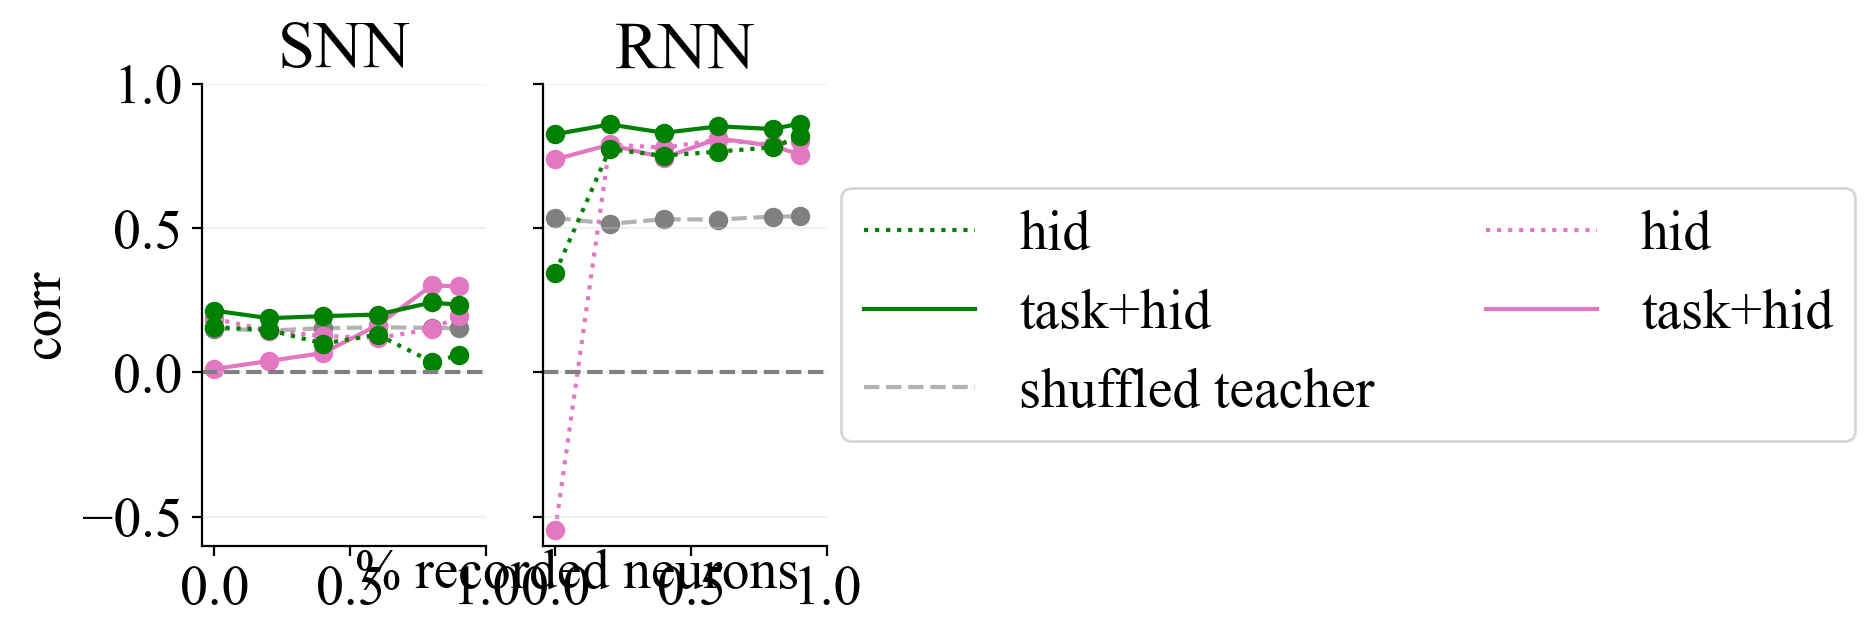

(3, 7, 4, 2)

In [ ]:
def get_level_recordings(data_set_name,model,metric,hil_levels,sparsity='',diff=False,mode='students',student=0):
    """
    plot metric over levels of hidden-layer recordings for SNN, RNN, MSE hidden loss and task+MSE hidden loss
    """

    models=['SNN', 'RNN']
    df = pd.read_csv(f'all_test_metrics_{data_set_name}_{models[0]}{sparsity}.csv')
    df_means = get_df_means(df,data_set_name)
    
    values_all, values_shuffled_all,values_shuffled_std_all, values_std_all,objectives,arr_values,arr_values_shuffled = get_values(df_means,metric,0)

    N=len(hil_levels)
    M=len(objectives)

    all_results = np.zeros((3,N,M,2)) #students+shuffle x levels x objectives x models

    for i, hil_add in enumerate(hil_levels):
        values_all, values_shuffled_all,values_shuffled_std_all, values_std_all,objectives,arr_values,arr_values_shuffled = get_values(df_means,metric,hil_add)
        all_results[:2,i,:,0] = values_all[:,-1,:]
        all_results[2,i,:,0] = values_shuffled_all[-1,:]
    try:
        df = pd.read_csv(f'all_test_metrics_{data_set_name}_{models[1]}{sparsity}.csv')
        df_means = get_df_means(df,data_set_name)
        
        for i, hil_add in enumerate(hil_levels):
            values_all, values_shuffled_all,values_shuffled_std_all, values_std_all,objectives,arr_values,arr_values_shuffled = get_values(df_means,metric,hil_add)
            all_results[:2,i,:,1] = values_all[:,-1,:]
            all_results[2,i,:,1] = values_shuffled_all[-1,:]
    except:
        pass

    colors=['green','tab:pink','gray']
    
    if mode == 'obj':
        fig,axs=plt.subplots(1,2,figsize=(5,3),sharey='row',sharex=True)
        for i, model in enumerate(models):
            axs[i].plot(hil_levels[:],all_results[0,:,2,i],label='hid',color=colors[0],zorder=1,linestyle=':')
            axs[i].plot(hil_levels[:],all_results[0,:,3,i],label='task+hid',color=colors[0],zorder=1)

            axs[i].plot(hil_levels[:],np.mean(all_results[2,:,2:,i],axis=1),label='shuffled teacher',color=colors[2],linestyle='--',alpha=0.6,zorder=-1)

            axs[i].plot(hil_levels[:],all_results[1,:,2,i],label='hid',color=colors[1],zorder=0,linestyle=':')
            axs[i].plot(hil_levels[:],all_results[1,:,3,i],label='task+hid',color=colors[1],zorder=0)
            

            axs[i].scatter(hil_levels[:],all_results[0,:,2,i],color=colors[0],zorder=1)
            axs[i].scatter(hil_levels[:],all_results[0,:,3,i],color=colors[0],zorder=1)

            axs[i].scatter(hil_levels[:],all_results[1,:,2,i],color=colors[1],zorder=0)
            axs[i].scatter(hil_levels[:],all_results[1,:,3,i],color=colors[1],zorder=0)
            axs[i].scatter(hil_levels[:],np.mean(all_results[2,:,2:,i],axis=1),color=colors[2],alpha=1.0,zorder=-1)
            
            axs[i].grid(axis='y',zorder=-2.0, color='lightgray', alpha=0.3)

            axs[i].axhline(y=0, color='gray', linestyle='--')
            axs[i].set_title(model)
        #plt.suptitle(data_set_name)
        axs[0].set_ylabel('corr')

        #axs[1].set_xlabel('% recorded neurons')
        fig.text(0.5, 0.04, '% recorded neurons', ha='center')

        axs[1].set_xticks([0.0,0.5,1.0])
        if legend:
            fig.subplots_adjust(right=0.75)

            axs[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.,ncol=legend)
        if 'corr' in metric:
            axs[0].set_ylim(-0.6,1)
            axs[1].set_ylim(-0.6,1)
        else:
            axs[0].set_ylim(0,290)
            axs[1].set_ylim(10**(-3),25000)

            axs[1].set_yscale("log")
        


    if mode == 'students':
        fig,axs=plt.subplots(2,2,figsize=(7,5),sharey='row',sharex=True)
        for i, model in enumerate(models):
            axs[i,0].plot(hil_levels[:],all_results[0,:,2,i],label='single-neuron',color=colors[0],zorder=1)
            axs[i,0].plot(hil_levels[:],all_results[1,:,2,i],label='weights',color=colors[1],zorder=0)
            axs[i,0].plot(hil_levels[:],all_results[2,:,2,i],label='baseline',color=colors[2],linestyle='--',alpha=0.6,zorder=-1)
            axs[i,0].scatter(hil_levels[:],all_results[0,:,2,i],color=colors[0],zorder=1)
            axs[i,0].scatter(hil_levels[:],all_results[1,:,2,i],color=colors[1],zorder=0)
            axs[i,0].scatter(hil_levels[:],all_results[2,:,2,i],color=colors[2],alpha=1.0,zorder=-1)
            
            axs[i,1].plot(hil_levels[:],all_results[0,:,3,i],label='single-neuron',color=colors[0],zorder=1)
            axs[i,1].plot(hil_levels[:],all_results[1,:,3,i],label='weights',color=colors[1],zorder=0)
            axs[i,1].plot(hil_levels[:],all_results[2,:,3,i],label='baseline',color=colors[2],linestyle='--',alpha=0.6,zorder=-1)
            axs[i,1].scatter(hil_levels[:],all_results[0,:,3,i],color=colors[0],zorder=1)
            axs[i,1].scatter(hil_levels[:],all_results[1,:,3,i],color=colors[1],zorder=0)
            axs[i,1].scatter(hil_levels[:],all_results[2,:,3,i],color=colors[2],alpha=1.0,zorder=-1)
            axs[i,0].grid(axis='y',zorder=-2.0, color='lightgray', alpha=0.3)
            axs[i,1].grid(axis='y',zorder=-2.0, color='lightgray', alpha=0.3)

            axs[i,0].axhline(y=0, color='gray', linestyle='--')
            axs[i,1].axhline(y=0, color='gray', linestyle='--')
        axs[0,0].set_title('MSE hidden')
        axs[0,1].set_title('Task + MSE hidden')
        axs[1,0].set_xlabel('% recorded neurons')
        axs[1,1].set_xlabel('% recorded neurons')

        axs[1,0].set_xticks([0.0,0.5,1.0])
        axs[1,1].set_xticks([0.0,0.5,1.0])
        

        #axs[1,0].set_ylabel('MSE hidden unrecorded')
        #axs[1,0].set_ylabel('MSE hidden')
        if legend:
            fig.subplots_adjust(right=0.75)

            axs[0,1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.,ncol=legend)

        axs[0,1].set_ylim(-0.6,1)
        axs[1,1].set_ylim(-0.6,1)
        #axs[1,0].set_yscale("log")
        #axs[0,0].set_yscale("log")

    for pos in ['right', 'top']:
        plt.gca().spines[pos].set_visible(False)
    sns.despine()
        
    plt.tight_layout()
    plt.show()

    return all_results

metric='test_corr_V_hidden_unrec'
data_set_name='RMS'
hil_levels=[0,0.2,0.4,0.6,0.8,0.9,1.0]
legend=2#2
mode='obj'#'students'
diff=False
student=1
plt.rcParams.update({'font.size': 20})
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] 
plt.rcParams["figure.dpi"]=200
all_results=get_level_recordings(data_set_name,model,metric,hil_levels,sparsity='',diff=diff,mode=mode,student=student)
all_results.shape


(4, 3, 2)


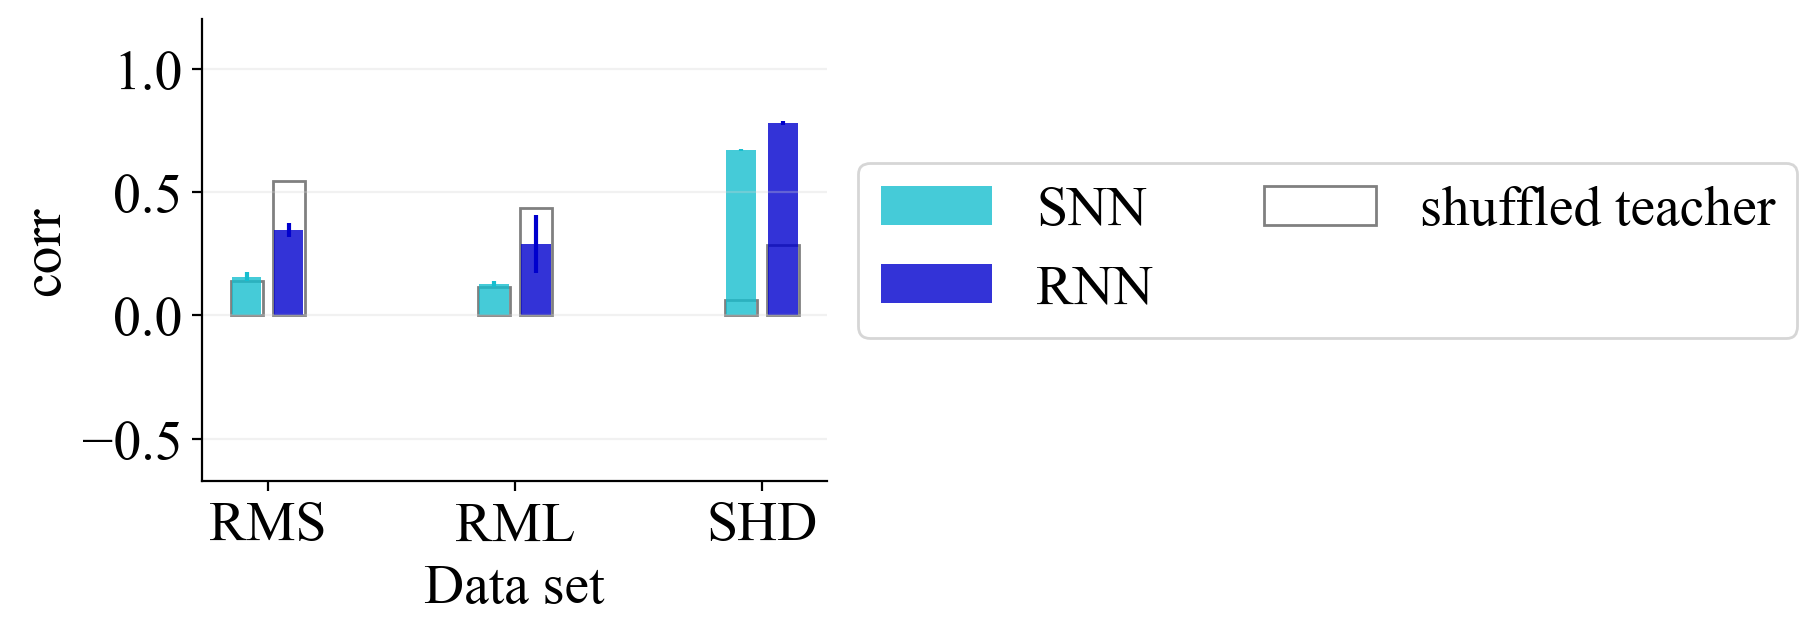

min: -0.6738723302950349, max: 1.2, shuffled mac None
(4, 3, 2)


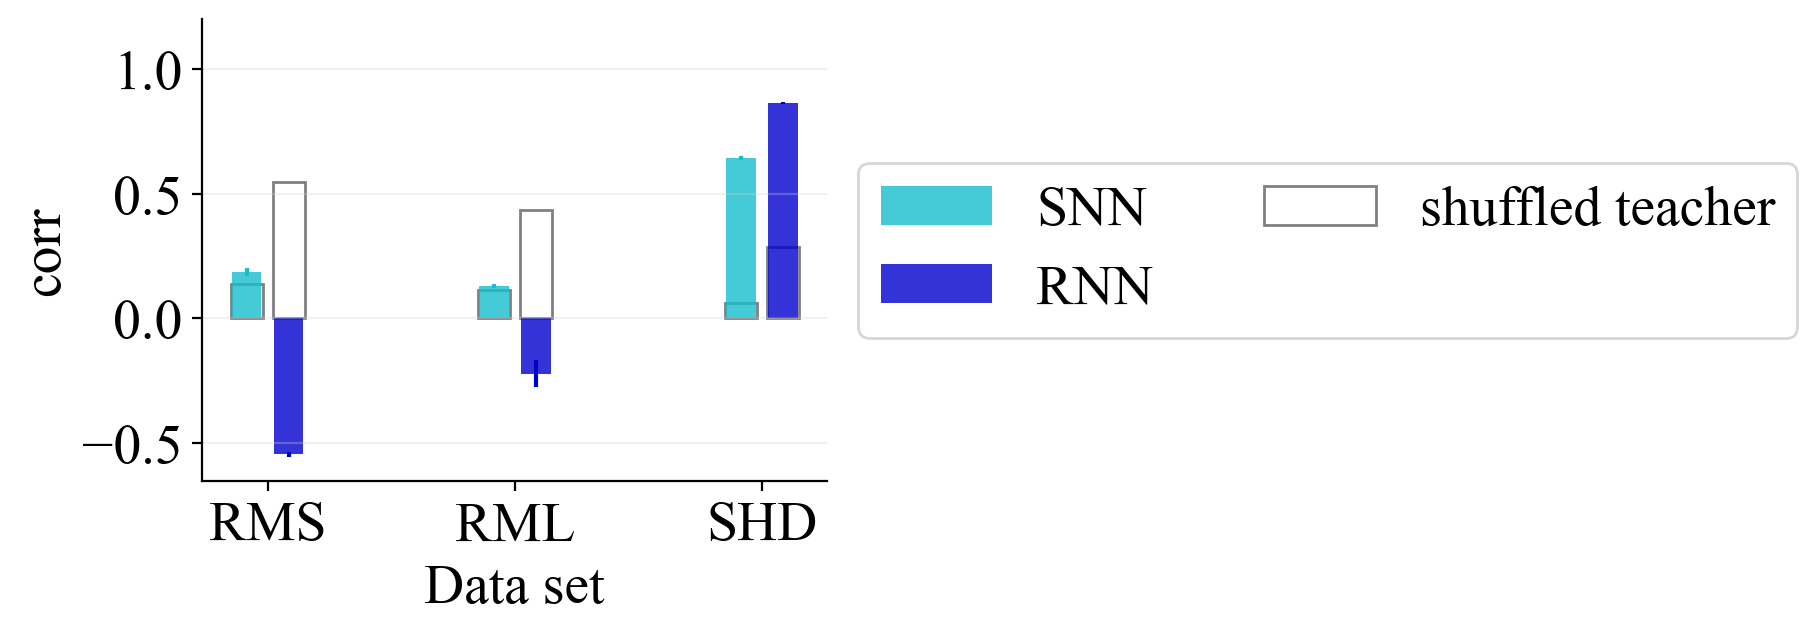

min: -0.6548728318549368, max: 1.2, shuffled mac None


In [109]:
students=['oi','ov']
teachers = ['oi','ow','wi']
colors=['#7d54b2', '#e57439', '#5ac5db', ]
import matplotlib as mpl
cmap = mpl.colormaps['viridis']
colors2 = cmap(np.linspace(0, 1, 4))
plot='task_0_SNN_RNN_oi' #'table_structure', 'loss','dataset_task','dataset_sparsity','lowrank_control','task_0','task_0_SNN_RNN_oi','task_heatmap'
if 'lowrank' in plot:
    sparsity='_lowrank'
else:
    sparsity=''

metric='test_corr_V_hidden_unrec'
mode='absolute'
logscale=0
hil_add=0.0
data_set_name='RMS'
model='SNN'
titles=0
tests=0
legend=2 #for 4 cols: 4
figsize=(5,3)
plt.rcParams.update({'font.size': 20})
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] 
plt.rcParams["figure.dpi"]=200
values_all, values_shuffled_all, values_shuffled_std_all, values_std_all,objectives = show_teacher_student_loss(teachers,students,data_set_name,model,metric, mode, logscale,hil_add,plot,sparsity,titles=titles,tests=tests,legend=legend,figsize=figsize)

(20, 501)


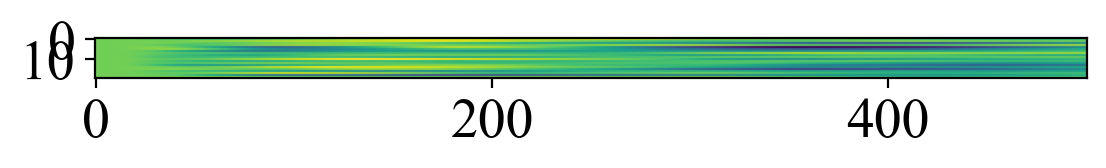

(256, 501, 20)
sort rec shape: (128,)


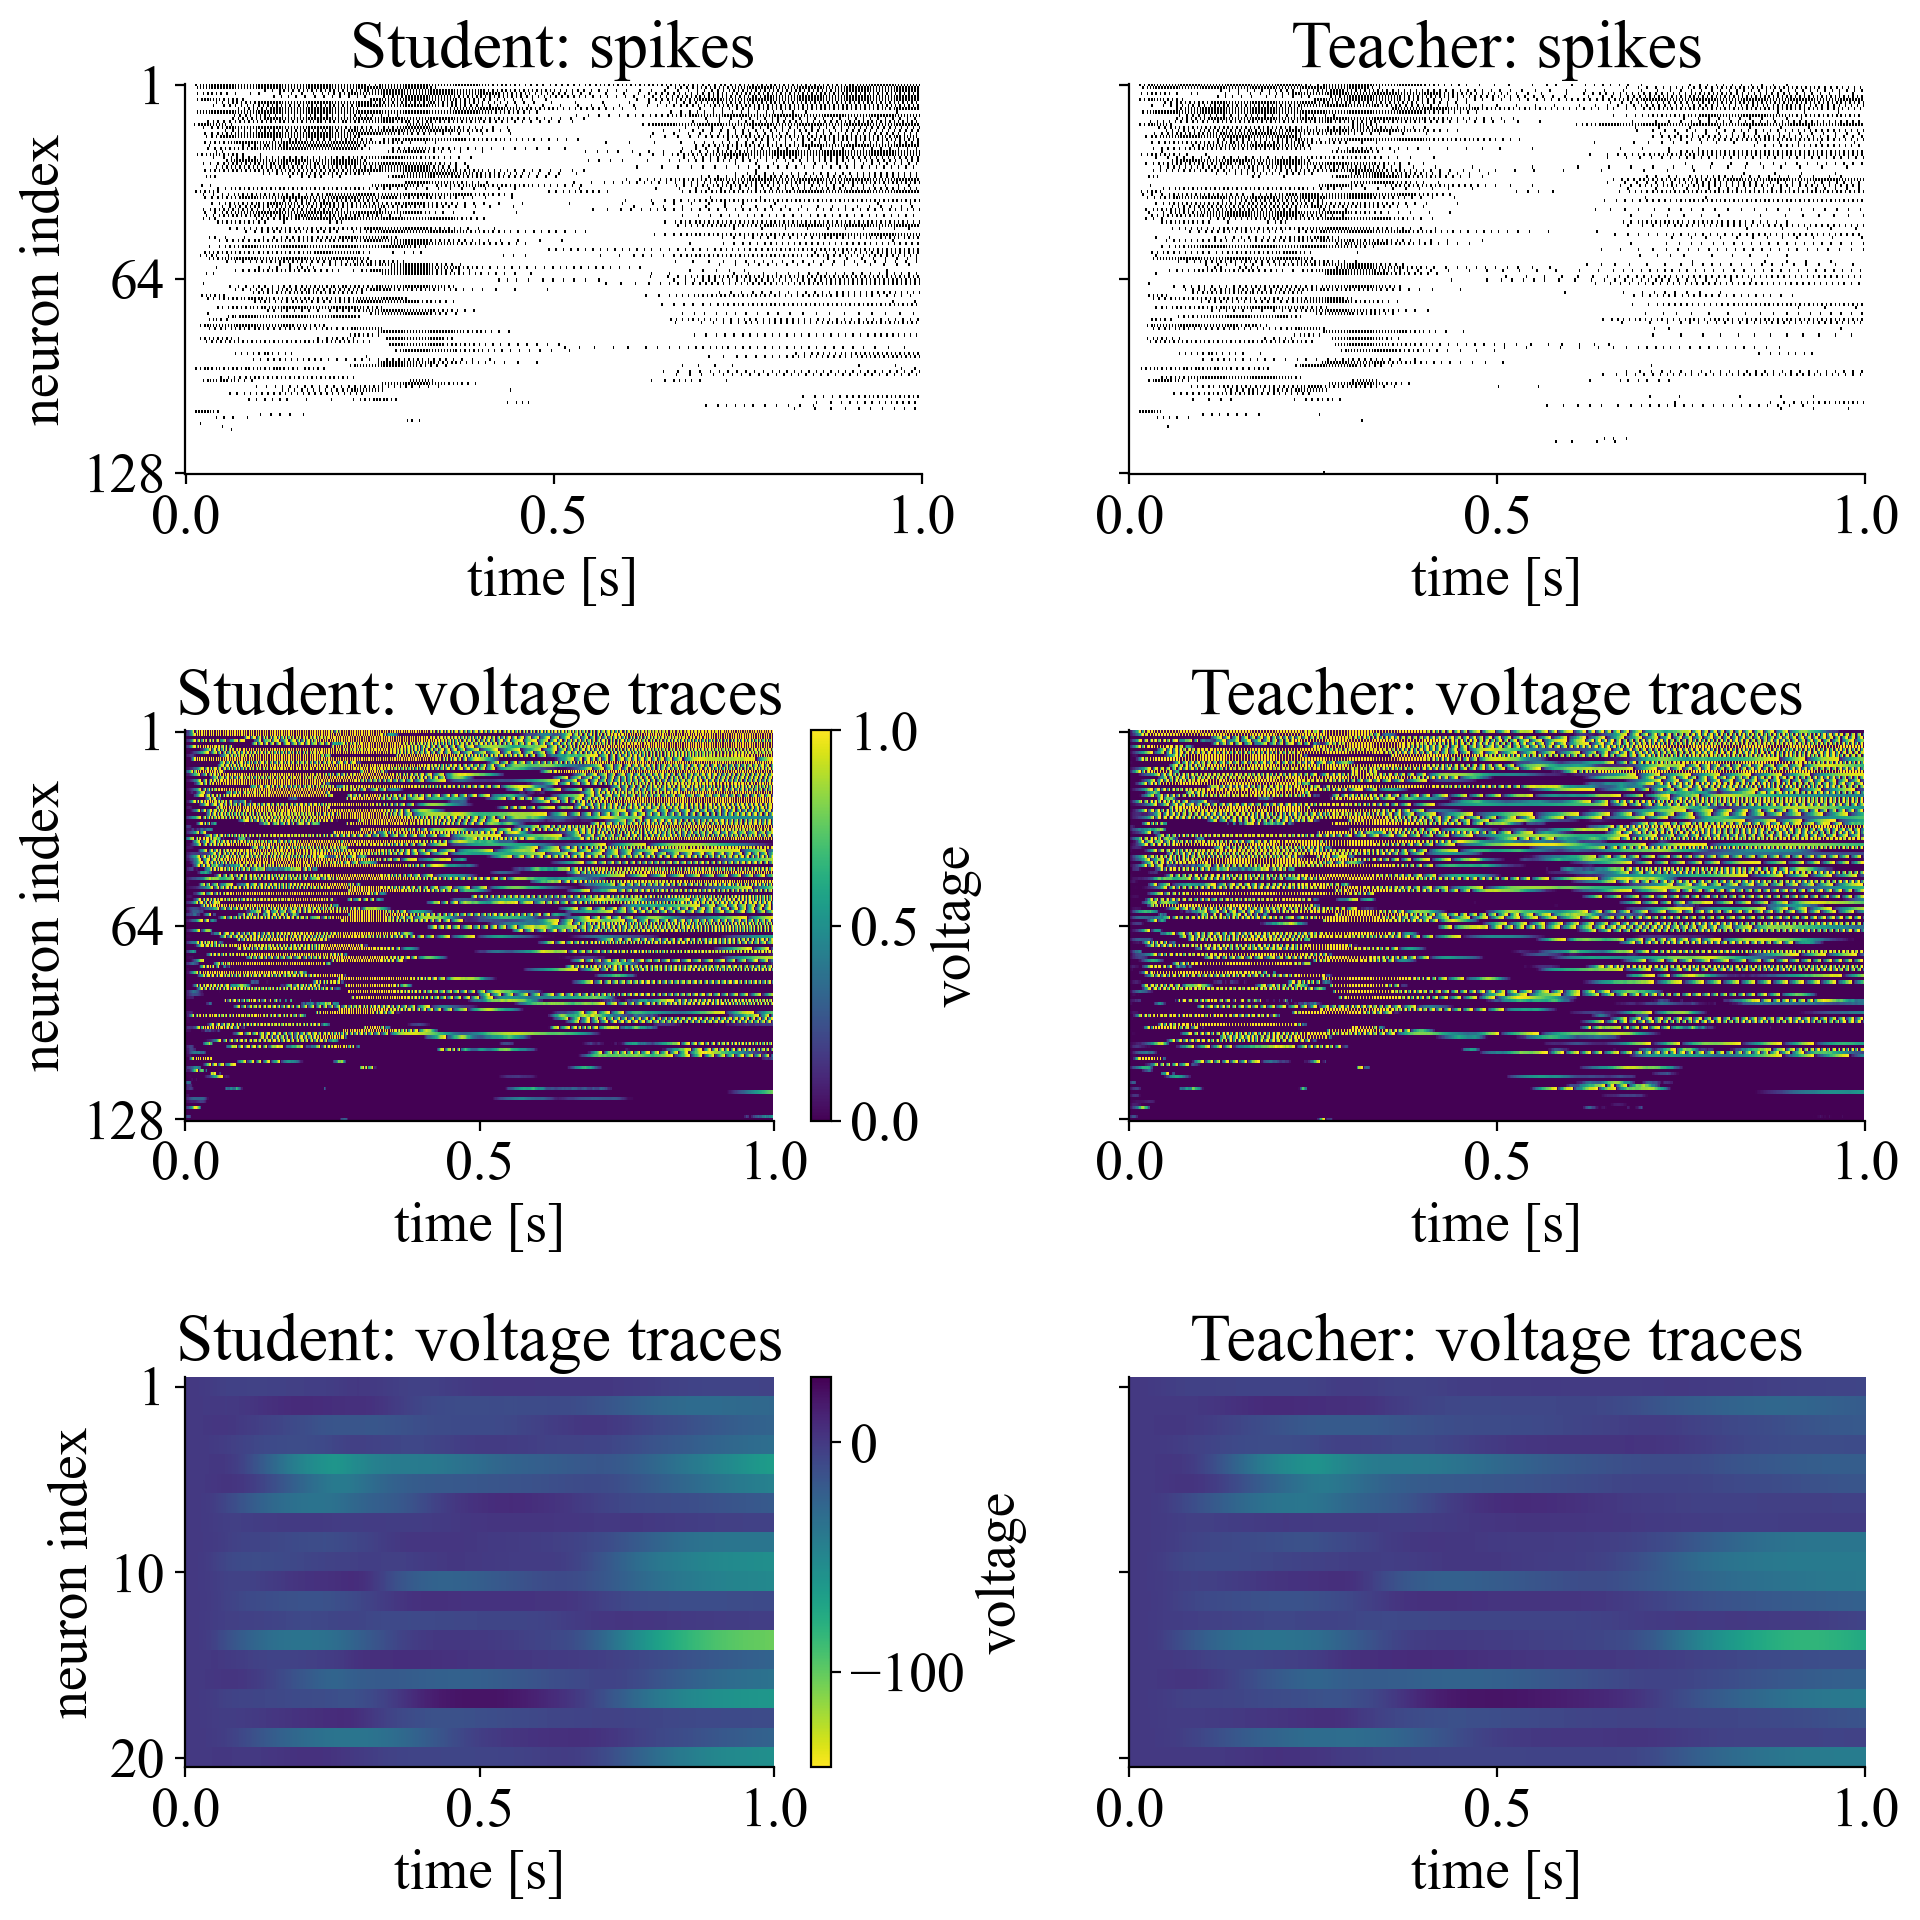

91


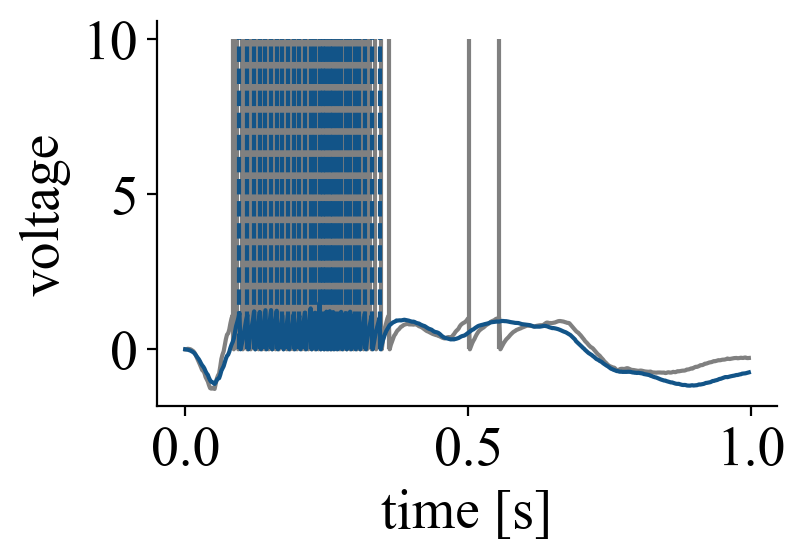

1


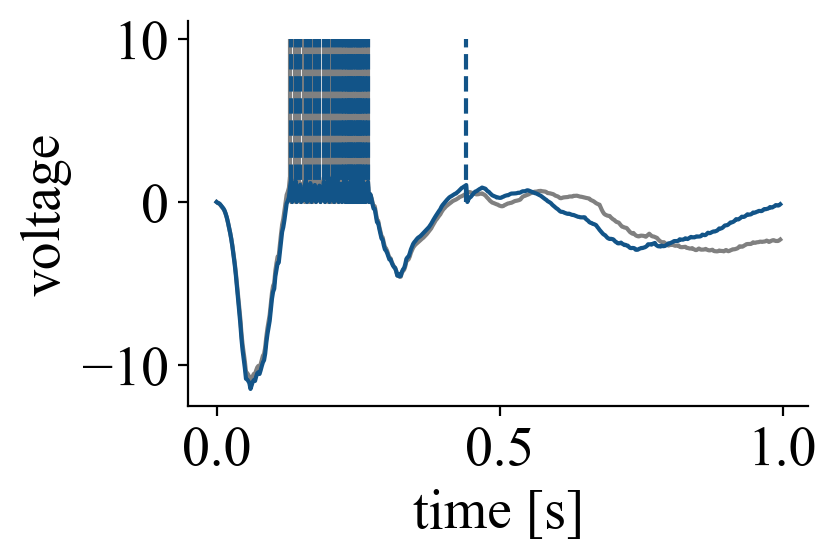

78


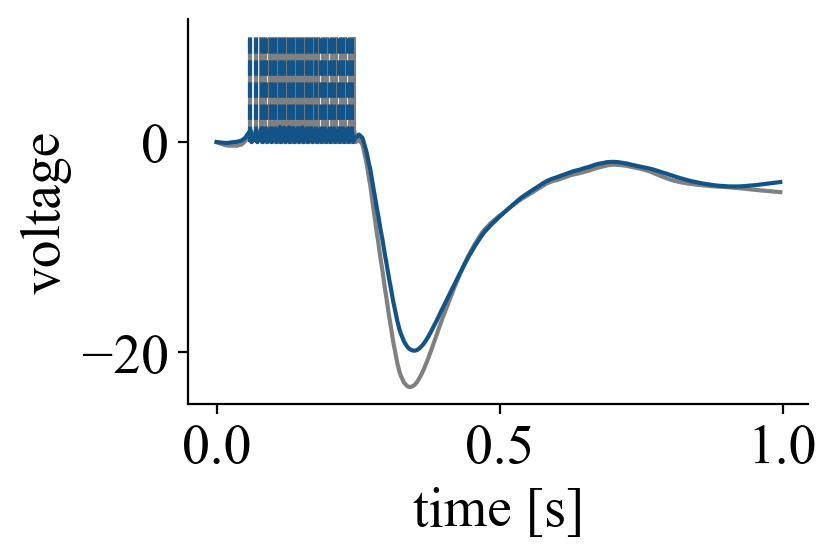

idx is 16
78


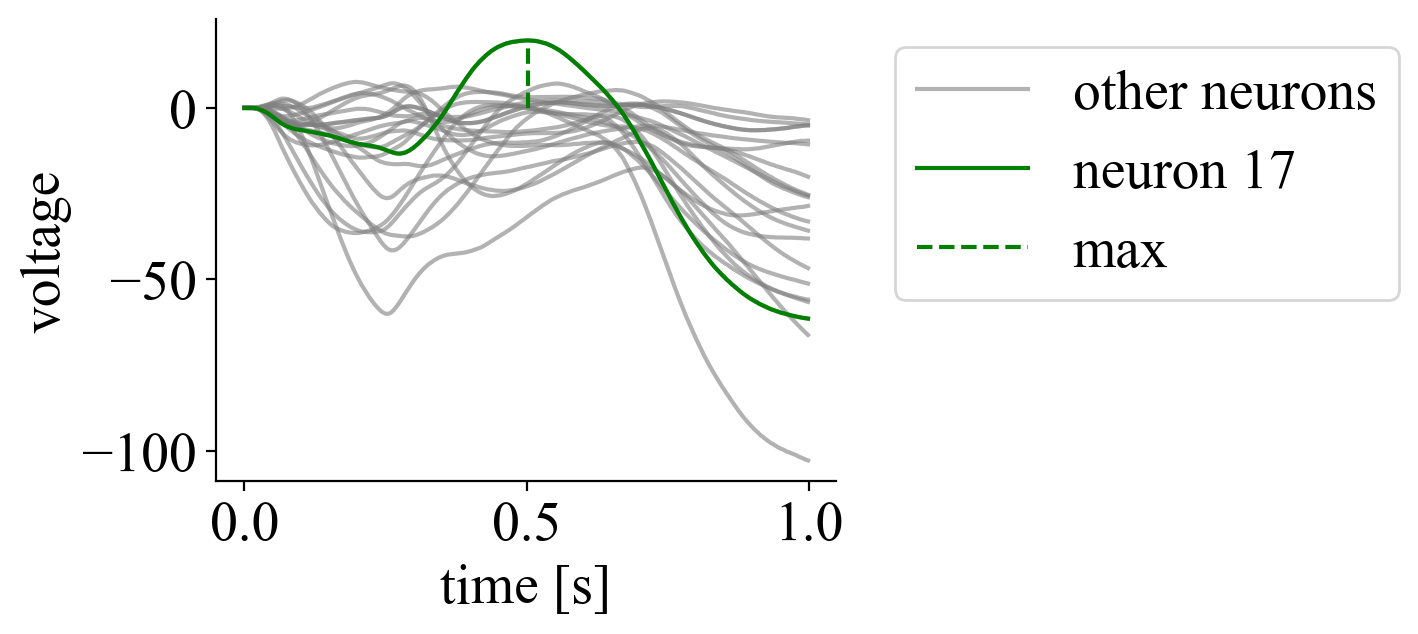

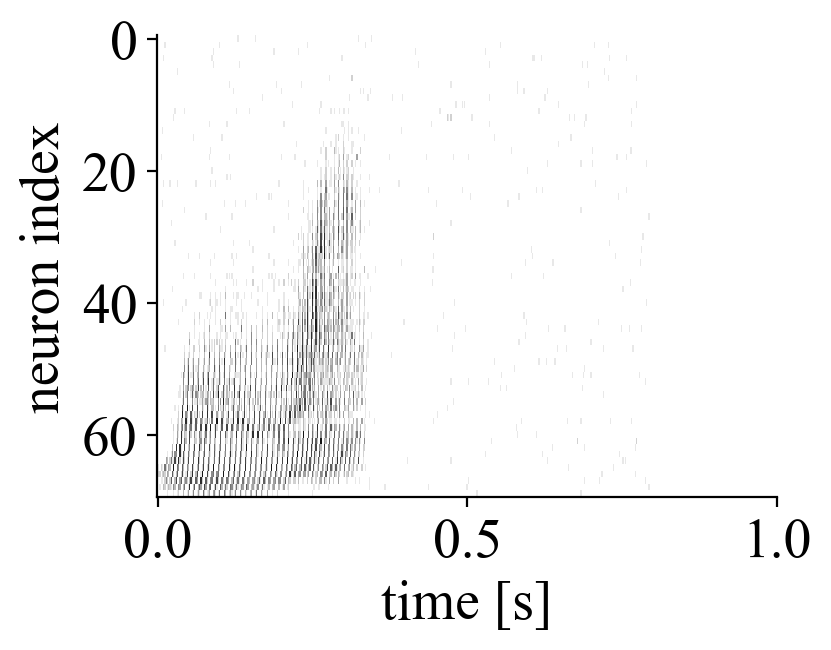

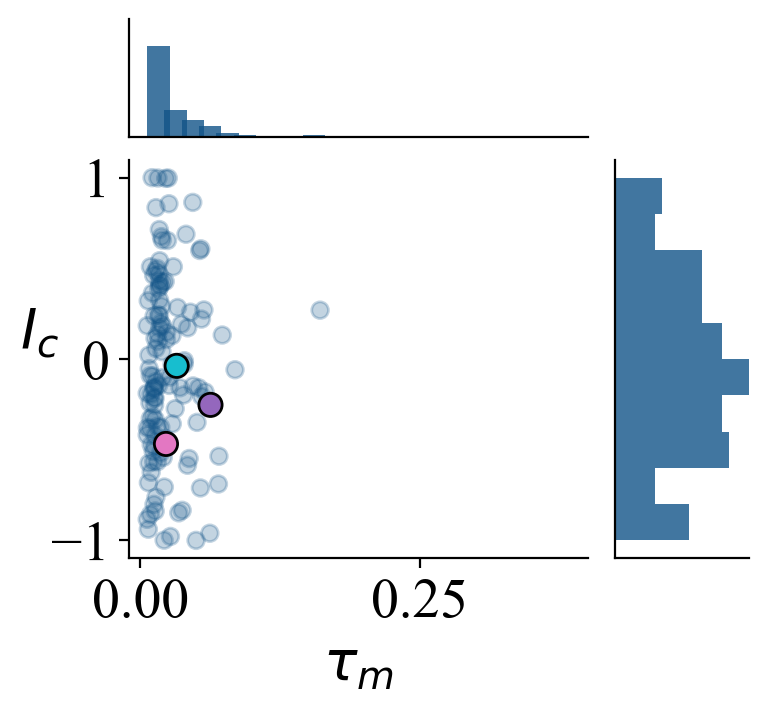

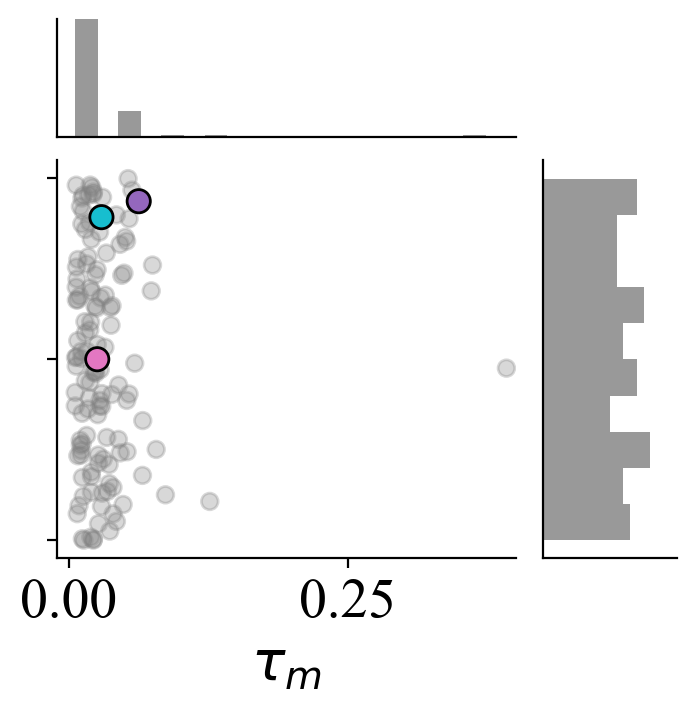

min tau mem: 0.005995478837446241
min tau mem: 0.005999527015292503


In [ ]:
def plot_teacher_student():
    """data was downloaded from HPC in this case - use evaluate/forward_pass.ipynb to save data from forward passes into plot_outputs folder"""
    spk_rec=np.load('plot_outputs/spk_rec.npy')
    target_spk_rec=np.load('plot_outputs/spk_rec_t.npy')
    mem_rec=np.load('plot_outputs/mem_rec.npy')
    target_mem_rec=np.load('plot_outputs/mem_rec_t.npy')
    output=np.load('plot_outputs/out.npy')
    target_output=np.load('plot_outputs/out_t.npy')

    print(target_output.shape)
    sample_idx = np.argmin(np.mean(np.abs(mem_rec-target_mem_rec),axis=(1,2)))
    
    fig,axs=plt.subplots(3,2,figsize=(10,10)) 
    sample_idx=10
    Nticks=3

    sort_rec_unrec=np.argsort(np.sum(spk_rec[sample_idx,:,:],0))[::-1]
    print(f'sort rec shape: {sort_rec_unrec.shape}')



    #hidden spikes
    _,time,neurons1=spk_rec.shape
    dt=0.002
    axs[0,0].imshow(spk_rec[sample_idx,:,:][:,sort_rec_unrec].T, cmap='binary', aspect="auto",interpolation='none')
    axs[0,0].set_title(f'Student: spikes')


    axs[0,1].imshow(target_spk_rec[sample_idx,:,:][:,sort_rec_unrec].T, cmap='binary', aspect="auto",interpolation='none')
    axs[0,1].set_title(f'Teacher: spikes')

    cmap='magma'
    #,(0.7,'#f7baff')
    colors = [(0,'#e61bff'),(0.05,'#394184'), (0.4, '#0f5aa3') ,(0.8, '#5ae3ff'), (1.0, '#ffffff')] # Positions and colors
    cmap_name3 = 'my_custom_cmap3'
    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list(cmap_name3, colors, N=256).reversed()
    cmap='viridis'
    #hidden voltages
    vmin,vmax=0,target_spk_rec.max()

    im = axs[1,0].imshow(mem_rec[sample_idx,:,:][:,sort_rec_unrec].T, cmap=cmap, aspect="auto",vmin=vmin,vmax=vmax,interpolation='none')
    plt.colorbar(im,label='voltage')
    axs[1,0].set_title(f'Student: voltage traces')

    axs[1,1].imshow(target_mem_rec[sample_idx,:,:][:,sort_rec_unrec].T, cmap=cmap, aspect="auto",vmin=vmin,vmax=vmax,interpolation='none')
    axs[1,1].set_title(f'Teacher: voltage traces')

    #output voltages
    vmin,vmax=target_output.min(),target_output.max()
    #vmin,vmax=-1,vmax
    _,time,neurons2=output.shape
    cmap='viridis_r'
    im=axs[2,0].imshow(output[sample_idx,:,:].T, cmap=cmap, aspect="auto",vmin=vmin,vmax=vmax,interpolation='none')
    plt.colorbar(im,label='voltage', norm='log')
    axs[2,0].set_title(f'Student: voltage traces')

    axs[2,1].imshow(target_output[sample_idx,:,:].T, cmap=cmap, aspect="auto",vmin=vmin,vmax=vmax,interpolation='none')
    axs[2,1].set_title(f'Teacher: voltage traces')

    for i in np.arange(3):
        for j in np.arange(2):
            for pos in ['top', 'right']:
                #axs[0].gca().spines[pos].set_visible(False)
                axs[i,j].spines[pos].set_visible(False)
                if i<2:
                    if j>0:
                        axs[i,j].set_yticks(np.linspace(0,neurons1-1, num=Nticks), [])
                    else:
                        axs[i,j].set_yticks(np.linspace(0,neurons1-1, num=Nticks), np.linspace(1,neurons1, num=Nticks).astype(int))
                else:
                    if j>0:
                        axs[i,j].set_yticks(np.linspace(0,neurons2-1, num=Nticks), [])
                    else:
                        axs[i,j].set_yticks(np.linspace(0,neurons2-1, num=Nticks), np.linspace(1,neurons2, num=Nticks).astype(int))
                    
                axs[i,j].set_xticks(np.linspace(0,time, num=Nticks), np.round(np.linspace(0,time*dt, num=Nticks),1))
                axs[i,j].set_xlabel("time [s]")
                if j==0:
                    axs[i,j].set_ylabel("neuron index")


    plt.tight_layout()
    plt.show()

    input=np.load('plot_outputs/input.npy')[:, sample_idx, 0, :]
    target=np.load('plot_outputs/target.npy')[sample_idx]
    # example hidden________________________________

    for k in np.arange(99,102): #28,25,33

        plt.figure(figsize=(4,2.5))
        plt.plot(target_mem_rec[sample_idx,:,:][:,sort_rec_unrec[k]].T,'gray',label='Teacher')
        #plt.plot(target_mem_rec[sample_idx,:,:][:,sort_rec_unrec[k]][:2].T,'gray',label='Teacher')
        plt.vlines(x=np.where(target_spk_rec[sample_idx,:,:][:,sort_rec_unrec[k]].T), ymin=0, ymax=10, color='gray')
        plt.vlines(x=np.where(spk_rec[sample_idx,:,:][:,sort_rec_unrec[k]].T), ymin=0, ymax=10, color='#125488', linestyle='--')
        plt.plot(mem_rec[sample_idx,:,:][:,sort_rec_unrec[k]].T,'#125488', label='Student')
        #plt.plot(mem_rec[sample_idx,:,:][:,sort_rec_unrec[k]][:2].T,'#125488', label='Student')
        

        #plt.legend()
        sns.despine()
        print(sort_rec_unrec[k])
        #plt.title(k)
        plt.xticks(np.linspace(0,time, num=Nticks), np.round(np.linspace(0,time*dt, num=Nticks),1))
        plt.xlabel("time [s]")
        plt.ylabel('voltage')
        plt.show()

    # example output________________________________

    plt.figure(figsize=(4,3))

    idx=np.argmax(np.max(output[sample_idx,:,:], axis=0))
    xidx=np.argmax(output[sample_idx,:,idx])
    print(f'idx is {idx}')
    plt.plot(output[sample_idx,:,:],'tab:gray',alpha=0.6)
    plt.plot(output[sample_idx,:,0],'tab:gray', label='other neurons',alpha=0.6)
    plt.plot(output[sample_idx,:,idx],'green', label=f'neuron {target+1}')
    plt.vlines(x=xidx, ymin=0, ymax=output[sample_idx,xidx,idx], color='green',label='max', linestyle='--')


    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    sns.despine()
    print(sort_rec_unrec[k])
    plt.xticks(np.linspace(0,time, num=Nticks), np.round(np.linspace(0,time*dt, num=Nticks),1))
    plt.xlabel("time [s]")
    plt.ylabel('voltage')
    plt.show()

    # example input________________________________

    plt.figure(figsize=(4,3))
    plt.imshow(input.T, cmap='binary', aspect="auto",interpolation='none')

    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    sns.despine()
    plt.xticks(np.linspace(0,time, num=Nticks), np.round(np.linspace(0,time*dt, num=Nticks),1))
    plt.xlabel("time [s]")
    plt.ylabel('neuron index')
    plt.show()

    # student________________________________
    mems=np.load('plot_outputs/mems.npy')
    mems_t=np.load('plot_outputs/mems_target.npy')
    Ics=np.load('plot_outputs/Ics.npy')
    Ics_t=np.load('plot_outputs/Ics_target.npy')
    v=np.load('plot_outputs/v.npy')
    v_target=np.load('plot_outputs/v_target.npy')

    
    fig = plt.figure(figsize=(4,3.5))
    gs = GridSpec(4, 4)
    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0,0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])

    colors=['green', 'red']
    i=0
        
    x=mems
    y = Ics
    import matplotlib as mpl
    cmap = mpl.colormaps['cool']
    colors = cmap(np.linspace(0.3, 0.9, 3))
    c=np.zeros(128,dtype='object')
    c[:]='#125488'
    c[0]='tab:cyan'
    c[63]='tab:purple'
    c[-1]='tab:pink'
    idx=c=='#125488'



    import matplotlib.colors as colors
    cmap = plt.cm.cool.reversed()
    cmap = colors.LinearSegmentedColormap.from_list('trunc_cm', cmap(np.linspace(0.3, 0.9, 100)))
    ax_scatter.scatter(x[idx], y[idx], c=c[idx], alpha=0.25)#cmap='cool')
    ax_scatter.scatter(x[~idx], y[~idx], c=c[~idx], alpha=1.0,edgecolors='black', linewidths=1.0,s=70)#cmap='cool')

    color='#125488'

    ax_hist_x.hist(x, color=color,alpha=0.8,width=0.02)
    ax_hist_y.hist(y, orientation = 'horizontal', color=color,alpha=0.8)

    ax_scatter.set_ylim(-1.1,1.1)
    ax_scatter.set_xlim(-0.01,0.4)
    ax_hist_x.set_xlim(-0.01,0.4)
    ax_hist_x.set_ylim(0,100)
    ax_hist_x.set_xticks([])
    ax_hist_y.set_xticks([])
    ax_hist_x.set_yticks([])
    ax_hist_y.set_yticks([])
    #ax_hist_x.set_ylim(-0.1,1.1)
    ax_hist_y.set_xlim(0.0,20)
    ax_hist_y.set_ylim(-1.1,1.1)
    ax_scatter.set_xlabel(r'$\tau_m$')
    ax_scatter.set_yticks([-1,0,1])
    ax_scatter.set_ylabel(r'$I_c$', rotation='horizontal')
    #plt.suptitle(r'joint distribution of $\tau_m$ and $I_c$')
    axs=[ax_scatter, ax_hist_x, ax_hist_y]
    for i in np.arange(3):
        for pos in ['top', 'right']:
            #axs[0].gca().spines[pos].set_visible(False)
            axs[i].spines[pos].set_visible(False)
    #plt.tight_layout()
    plt.show()
    
    # teacher________________________________
    fig = plt.figure(figsize=(4,3.5))
    gs = GridSpec(4, 4)
    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0,0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])
    colors=['green', 'red']
    i=0
        
    x=mems_t
    y = Ics_t

    c=np.arange(128)
    
    cmap = plt.cm.cool
    cmap = colors.LinearSegmentedColormap.from_list('trunc_cm', cmap(np.linspace(0.1, 0.9, 100)))
    c=np.zeros(128,dtype='object')
    c[:]='gray'
    c[0]='tab:cyan'
    c[63]='tab:purple'
    c[-1]='tab:pink'
    ax_scatter.scatter(x[idx], y[idx], c=c[idx], alpha=0.3)#cmap='cool')
    ax_scatter.scatter(x[~idx], y[~idx], c=c[~idx], alpha=1.0,edgecolors='black', linewidths=1.0,s=70)#cmap='cool')

    color='gray'

    ax_hist_x.hist(x, color=color,alpha=0.8,width=0.02)
    ax_hist_y.hist(y, orientation = 'horizontal', color=color,alpha=0.8)

    ax_scatter.set_ylim(-1.1,1.1)
    ax_scatter.set_xlim(-0.01,0.4)
    ax_hist_x.set_xlim(-0.01,0.4)
    ax_hist_x.set_xticks([])
    ax_hist_y.set_xticks([])
    ax_hist_x.set_yticks([])
    ax_hist_y.set_yticks([])
    ax_scatter.set_yticks([-1,0,1],[])
    ax_hist_x.set_ylim(0,100)
    #ax_hist_x.set_ylim(-0.1,1.1)
    ax_hist_y.set_xlim(0.0,20)
    ax_hist_y.set_ylim(-1.1,1.1)
    ax_scatter.set_xlabel(r'$\tau_m$')
    #ax_scatter.set_ylabel(r'$I_c$', rotation='horizontal')
    #plt.suptitle(r'joint distribution of $\tau_m$ and $I_c$')
    #plt.tight_layout()
    axs=[ax_scatter, ax_hist_x, ax_hist_y]
    for i in np.arange(3):
        for pos in ['top', 'right']:
            #axs[0].gca().spines[pos].set_visible(False)
            axs[i].spines[pos].set_visible(False)
    plt.show()
    print(f'min tau mem: {mems.min()}')
    print(f'min tau mem: {mems_t.min()}')

plt.rcParams.update({'font.size': 20})
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] 
plt.rcParams["figure.dpi"]=200

plot_teacher_student()
